<a href="https://colab.research.google.com/github/FredLongo/MLDL_Project/blob/main/TeamProject_V04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Review with Video https://www.youtube.com/watch?v=hpfQE0bTeA4

#Code Section

In [78]:
# Connect to Drive
from google.colab import drive
drive.mount('/content/drive')




Mounted at /content/drive


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import pandas_ta as ta
from sklearn.preprocessing import MinMaxScaler
import warnings
from datetime import datetime, timedelta

"""#Now build the model"""

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate

""" performance evaluation """
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import math

pd.set_option('display.max_columns', None)




In [68]:
class MyLSTMModel:
    def __init__(self, indicators='^DJI',
                 ticker='ADM',
                 frame_days=10,
                 lstm_layers = 150,
                 start_date = '2012-03-11',
                 end_date='2022-07-10',
                 batch_size=15,
                 epochs=30,
                 run = False,
                 run_all=False,
                 verbose=1,
                 name=''):
        #Parameters
        self.name           = name
        self.indicators     = indicators
        self.ticker         = ticker
        self.run            = run
        self.run_all        = run_all
        #Data Setup
        self.start_date     = start_date
        self.end_date       = end_date
        self.frame_days     = frame_days
        self.ticker_list    = indicators + ',' +ticker
        self.ticker_list_ct  = len(self.ticker_list.split(','))
        self.tickers        = self.ticker_list.split(',')
        self.data = pd.DataFrame()
        #Model Setup
        self.model          = None
        self.lstm_layers    = lstm_layers
        self.batch_size     = batch_size
        self.epochs         = epochs
        self.verbose        = verbose
        #Report
        self.pred_diff    = np.array([])
        self.pred_diff_bias  = np.array([])
        self.pred_correctness = np.array([])
        self.pred_correctness_mean = np.array([])
        self.history = np.array([])
        self.fitting_elapse_time = None
        #Misc
        self.data_set = pd.DataFrame()
        self.data_set_scaled = np.array([])
        self.X        = np.array([])              # X[Column][Sample][Frame_day]
        self.X_train  = np.array([])
        self.X_test   = np.array([])
        self.y_train  = np.array([])
        self.y_test   = np.array([])
        self.y_pred   = np.array([])

        if self.name == '':
          self.name = ticker + '_F' + str(frame_days) + '_L' + str(lstm_layers)

        if self.run or self.run_all:
          self.Run()



    def Data__LoadAndPrep(self):
        #Download Data from Yahoo Finance
        self.data = yf.download(tickers=self.tickers, start=self.start_date, end=self.end_date)

        # Add all additional indicators
        for (_type, _ticker) in self.data.columns:
          if _type == 'Close':
            rsi_values = ta.rsi(self.data[(_type, _ticker)], length=15)
            self.data[('RSI', _ticker)] = rsi_values
            emaf_values = ta.rsi(self.data[(_type, _ticker)], length=20)
            self.data[('EMAF', _ticker)] = rsi_values
            emam_values = ta.rsi(self.data[(_type, _ticker)], length=100)
            self.data[('EMAM', _ticker)] = rsi_values
            emas_values = ta.rsi(self.data[(_type, _ticker)], length=150)
            self.data[('EMAS', _ticker)] = rsi_values

        # Add the Training an validation column info.
        self.data[('Target',self.ticker)] = self.data['Adj Close',self.ticker]-self.data['Open',self.ticker]                                # 1) Diff of current open and future close
        self.data[('Target',self.ticker)] = self.data['Target',self.ticker].shift(-1)                                                       #
        self.data[('TargetClass',self.ticker)] = [1 if self.data[('Target',self.ticker)][i]>0 else 0 for i in range(len(self.data))]        # 2) Classificaton approche 1= up 0 = down.
        self.data[('TargetNextClose',self.ticker)] = self.data[('Adj Close',self.ticker)].shift(-1)                                         # 3) Closing Price of the next day

        #Remove unused columns
        self.data.dropna(inplace=True)                                                       # Dropping values not their
        self.data.reset_index(inplace = True)                                                # rebuild index after removed values

        with warnings.catch_warnings():
          warnings.simplefilter("ignore", category=pd.errors.PerformanceWarning)
          self.data.drop([('Close', self.ticker)], axis=1, inplace=True)                       # Removing because we are going with Adjuested Close
          self.data.drop(['Date'], axis=1, inplace=True)                                       # Removing unsued Columns  (R1)


    def Data_Set__LoadAndPrep(self):
        self.data_set = self.data.iloc[:,0:len(self.data.columns)]#.values
        # Scale the dataset
        sc = MinMaxScaler(feature_range=(0,1))             # Apply Scaler to oour data to make it between 0 and `
        self.data_set_scaled = sc.fit_transform(self.data_set)


    def Data_Prep_Input(self):
        # Create frame of given candles
        self.X = []

        for j in range(len(self.data_set.columns) -1):#data_set_scaled[0].size):#2 columns are target not X         # Removing some of the columns  Adding volume
            self.X.append([])
            for i in range(self.frame_days, self.data_set_scaled.shape[0]):#framedays+2
                self.X[j].append(self.data_set_scaled[i-self.frame_days:i, j])

        #Swith Order, move axis from 0 to last position 2                               # Moves  X[Column][Sample][Frame_day]
                                                                                        #   to   X[Sample][Frame_day][Column]
        self.X = np.moveaxis( self.X, [0], [2])


        # Choose -1 for last column, classification else -2...
        self.X, yi =np.array(self.X), np.array(self.data_set_scaled[self.frame_days:,-1])
        y=np.reshape(yi,(len(yi),1))

        # split data into train test sets
        splitlimit = int(len(self.X)*0.8)          #point to slit at
        self.X_train, self.X_test = self.X[:splitlimit], self.X[splitlimit:]
        self.y_train, self.y_test = y[:splitlimit], y[splitlimit:]

        ############################################################
        ##   Build Model
        ############################################################
    def Build_Model(self):
        lstm_input = Input(shape=(self.frame_days, len(self.X[0][0])), name='lstm_input')      # Input layer
        inputs = LSTM(self.lstm_layers, name='first_layer')(lstm_input)                        # Long Short Term memory with lstm_layers # of layers
        inputs = Dense(1, name='dense_layer')(inputs)                                          # One Dense Layer
        output = Activation('linear', name='output')(inputs)                                   # Output layer
        self.model = Model(inputs=lstm_input, outputs=output)                                  # declare model
        adam = optimizers.Adam()                                                               # instanciate optimizer
        #self.model.compile(optimizer=adam, loss='mse', metrics=['accuracy'])                  # Compile model
        #self.model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['mse'])         # Compile model
        self.model.compile(optimizer=adam, loss='mse', metrics=['mae'])         # Compile model

    def Fit(self):
        start_time = datetime.now()
        print(f'___________{self.name}___________')
        self.history = self.model.fit(x=self.X_train,
                       y=self.y_train,
                       batch_size=self.batch_size,
                       epochs=self.epochs, #TODO Set back to 30
                       shuffle=True,
                       validation_data=(self.X_test, self.y_test),
                       verbose=self.verbose)
                       #validation_split = 0.1)
        end_time = datetime.now()
        self.fitting_elapse_time = end_time - start_time


    def Predict(self):
      self.y_pred = self.model.predict(self.X_test)

        ############################################################
        ### Evaluation and reports
        ############################################################
    def check_sign(self,number):
        if number > 0:
            return 1
        elif number < 0:
            return -1
        else:
            return 0


     # X_test = Open,	High,	Low,	Adj Close,	Volume,	RSI	EMAF,	EMAM,	EMAS,

    def Get_diffs(self):
        _size = self.y_test.shape[0]
        self.pred_correctness   = np.zeros(_size)
        self.pred_diff          = np.zeros(_size)
        self.pred_diff_bias      = np.zeros(_size)

        for i in range(_size):                                 # X[Sample][Frame_day][column]
          Opening    =  self.X_test[i][0][(self.ticker_list_ct * 4) -1]                        # Opening column for ticker is always (ticker_count * 4 -1)
          Actual     =  self.y_test[i]
          Predicted  =  self.y_pred[i]
          with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=DeprecationWarning)
            self.pred_diff[i]    = Predicted/Actual
            self.pred_diff_bias[i]  = 1 - (Predicted/Actual)
            if self.check_sign(Opening - Actual) == self.check_sign(Opening - Predicted):
              self.pred_correctness[i] = True;                                  #It predicted Correct!
            else: self.pred_correctness[i] = False;                             #It did predict correctly


                #Mean Squre Error
        self.mean_sqr_err =  mean_squared_error(self.y_test, self.y_pred)

        # Mean absolute Error
        self.mean_abs_err = mean_absolute_error(self.y_test, self.y_pred)

        self.pred_correctness_mean = self.pred_correctness.mean()
        self.pred_diff_mean = self.pred_diff.mean()
        self.pred_diff_bias_mean  = self.pred_diff_bias.mean()

         # R^2    = ?????


    def View_Performance_Report(self,show_graphs=True, show_report=True , graphs=[]):


        # Root Mean Squred Error.
        self.root_mean_sqr_err = math.sqrt(self.mean_sqr_err)
        print("############################################################################")
        print("  Model Setup:")
        print(f"                    Name: {self.name}")
        print(f"             LSTM_Layers: {self.lstm_layers}")
        print(f"               Bach_Size: {self.batch_size}")
        print(f"                  Epochs: {self.epochs}")
        print("  Data Setup:")
        print(f"                  Ticker: {self.ticker}")
        print(f"             Indicattors: {self.indicators}")
        print(f"              Start_Date: {self.start_date}")
        print(f"                End_Date: {self.end_date}")
        print(f"              Frame_Days: {self.frame_days}")
        print("  Result Data:")
        print(f'             mean_abs_err ={self.mean_abs_err}')
        print(f'             mean_sqr_err ={self.mean_sqr_err}')
        print(f'        root_mean_sqr_err ={self.root_mean_sqr_err}')
        print(f'           pred_diff_mean ={self.pred_diff_mean}')
        print(f'      pred_diff_bias_mean ={self.pred_diff_bias_mean}')
        print(f'    pred_correctness_mean ={self.pred_correctness_mean}')
        print("")

        #Plot Graph



        if  ('Eval_Loss' in graphs) or (show_graphs == True) :  # ('Pie' in show_graphs:)

          plt.figure(figsize=(12, 6))
          plt.subplot(1, 2, 1)
          plt.plot(self.history.history['mae'])
          plt.plot(self.history.history['val_mae'])
          plt.title('Evaluation Metric - Mean Absolute Error (MAE)')
          plt.ylabel('MAE')
          plt.xlabel('Epoch')
          plt.legend(['Train', 'Validation'], loc='upper left')


          # Plot training & validation loss values
          plt.subplot(1, 2, 2)
          plt.plot(self.history.history['loss'])
          plt.plot(self.history.history['val_loss'])
          plt.title('Model Loss - Mean Sqr Error (MSE) ')
          plt.ylabel('Loss')
          plt.xlabel('Epoch')
          plt.legend(['Train', 'Validation'], loc='upper left')
          plt.show()

        if  ('TrainingMAE' in graphs) or (show_graphs == True) :
          #####Break Down
          plt.figure(figsize=(12, 6))

          #plt.subplot(1, 1, 1)
          plt.plot(self.history.history['mae'])
          plt.title('Training Mean Absolute Error')
          plt.ylabel('MAE')
          plt.xlabel('Epoch')
          plt.legend(['Train'], loc='upper left')
          plt.show()


        if  ('ActVsPed_Line' in graphs) or (show_graphs == True) :  # ('Pie' in show_graphs:)
          # Actual vs Predicted Chart
          plt.figure(figsize=(16,8))
          plt.title('Actual Vs Prediction Results')
          plt.plot(self.y_test, color = 'black', label = 'Test')
          plt.plot(self.y_pred, color = 'green', label = 'pred')
          plt.legend()
          plt.show()

        if  ('ActVsPed_Pie' in graphs) or (show_graphs == True) :  # ('Pie' in show_graphs:)
          # Pie Chart
          values = [self.pred_correctness_mean, 1 - self.pred_correctness_mean ]
          labels = [f'Correctly Predicted {self.pred_correctness_mean:.2f}%', f'Incorect{1 - self.pred_correctness_mean:.2f}%']
          colors = ['g','r']
          explode = [0.1, 0]
          plt.title(f'Correct Prediction " {self.pred_correctness_mean:.2f}%  "of the time')
          plt.pie(values, labels=labels, colors=colors, explode=explode)
          plt.show




    def Run(self):
      self.Data__LoadAndPrep()
      self.Data_Set__LoadAndPrep()
      self.Data_Prep_Input()
      self.Build_Model()
      self.Fit()
      self.Predict()
      self.Get_diffs()
      if self.run_all == True:
        self.View_Performance_Report()









# Model Fit Section

# Model Training

In [71]:
Indicators    = '^DJI,^BSESN,^BVSP'
#Ticker = ['ADM','MSI','XOM']
Ticker = ['ADM']
frame_days = [10,20,30,40,50]
LSTM_layers = [30, 50,150,250,350]

#Ticker = ['ADM']
#frame_days = [10,30,50]
#LSTM_layers = [50]


model_list = []

for t in Ticker:
  for f in frame_days:
    for l in LSTM_layers:
      new_model = MyLSTMModel(indicators= Indicators, ticker=t,frame_days=f,lstm_layers=l,run=True)
      model_list.append(new_model)



[*********************100%%**********************]  4 of 4 completed


___________ADM_F10_L30___________
Epoch 1/30
122/122 [==============================] - 4s 11ms/step - loss: 0.0036 - mae: 0.0386 - val_loss: 0.0486 - val_mae: 0.1788
Epoch 2/30
122/122 [==============================] - 1s 7ms/step - loss: 3.6413e-04 - mae: 0.0149 - val_loss: 0.0428 - val_mae: 0.1704
Epoch 3/30
122/122 [==============================] - 1s 7ms/step - loss: 2.7030e-04 - mae: 0.0128 - val_loss: 0.0407 - val_mae: 0.1696
Epoch 4/30
122/122 [==============================] - 1s 7ms/step - loss: 2.0701e-04 - mae: 0.0112 - val_loss: 0.0357 - val_mae: 0.1598
Epoch 5/30
122/122 [==============================] - 1s 7ms/step - loss: 1.9739e-04 - mae: 0.0109 - val_loss: 0.0254 - val_mae: 0.1302
Epoch 6/30
122/122 [==============================] - 1s 8ms/step - loss: 1.7783e-04 - mae: 0.0103 - val_loss: 0.0243 - val_mae: 0.1308
Epoch 7/30
122/122 [==============================] - 1s 10ms/step - loss: 2.0664e-04 - mae: 0.0113 - val_loss: 0.0166 - val_mae: 0.1036
Epoch 8/30
122/1

[*********************100%%**********************]  4 of 4 completed


___________ADM_F10_L50___________
Epoch 1/30
122/122 [==============================] - 4s 15ms/step - loss: 0.0050 - mae: 0.0444 - val_loss: 0.0543 - val_mae: 0.1859
Epoch 2/30
122/122 [==============================] - 1s 8ms/step - loss: 4.2322e-04 - mae: 0.0162 - val_loss: 0.0428 - val_mae: 0.1624
Epoch 3/30
122/122 [==============================] - 1s 8ms/step - loss: 3.2990e-04 - mae: 0.0140 - val_loss: 0.0493 - val_mae: 0.1867
Epoch 4/30
122/122 [==============================] - 1s 7ms/step - loss: 2.8763e-04 - mae: 0.0132 - val_loss: 0.0312 - val_mae: 0.1385
Epoch 5/30
122/122 [==============================] - 1s 7ms/step - loss: 2.6134e-04 - mae: 0.0126 - val_loss: 0.0227 - val_mae: 0.1129
Epoch 6/30
122/122 [==============================] - 1s 8ms/step - loss: 2.1117e-04 - mae: 0.0112 - val_loss: 0.0225 - val_mae: 0.1164
Epoch 7/30
122/122 [==============================] - 1s 8ms/step - loss: 1.9876e-04 - mae: 0.0108 - val_loss: 0.0199 - val_mae: 0.1120
Epoch 8/30
122/12

[*********************100%%**********************]  4 of 4 completed


___________ADM_F10_L150___________
Epoch 1/30
122/122 [==============================] - 9s 53ms/step - loss: 0.0044 - mae: 0.0389 - val_loss: 0.0301 - val_mae: 0.1362
Epoch 2/30
122/122 [==============================] - 4s 29ms/step - loss: 2.7052e-04 - mae: 0.0128 - val_loss: 0.0249 - val_mae: 0.1260
Epoch 3/30
122/122 [==============================] - 3s 24ms/step - loss: 2.5602e-04 - mae: 0.0126 - val_loss: 0.0244 - val_mae: 0.1281
Epoch 4/30
122/122 [==============================] - 3s 26ms/step - loss: 2.0112e-04 - mae: 0.0109 - val_loss: 0.0198 - val_mae: 0.1159
Epoch 5/30
122/122 [==============================] - 3s 21ms/step - loss: 2.0888e-04 - mae: 0.0111 - val_loss: 0.0142 - val_mae: 0.0931
Epoch 6/30
122/122 [==============================] - 4s 32ms/step - loss: 1.9836e-04 - mae: 0.0109 - val_loss: 0.0125 - val_mae: 0.0883
Epoch 7/30
122/122 [==============================] - 3s 23ms/step - loss: 1.5898e-04 - mae: 0.0096 - val_loss: 0.0124 - val_mae: 0.0891
Epoch 8/30

[*********************100%%**********************]  4 of 4 completed


___________ADM_F10_L250___________
Epoch 1/30
122/122 [==============================] - 7s 39ms/step - loss: 0.0047 - mae: 0.0357 - val_loss: 0.0198 - val_mae: 0.1062
Epoch 2/30
122/122 [==============================] - 3s 28ms/step - loss: 1.9998e-04 - mae: 0.0108 - val_loss: 0.0203 - val_mae: 0.1157
Epoch 3/30
122/122 [==============================] - 4s 32ms/step - loss: 1.8767e-04 - mae: 0.0105 - val_loss: 0.0184 - val_mae: 0.1119
Epoch 4/30
122/122 [==============================] - 3s 24ms/step - loss: 1.4993e-04 - mae: 0.0092 - val_loss: 0.0138 - val_mae: 0.0951
Epoch 5/30
122/122 [==============================] - 3s 27ms/step - loss: 1.4678e-04 - mae: 0.0091 - val_loss: 0.0137 - val_mae: 0.0952
Epoch 6/30
122/122 [==============================] - 6s 49ms/step - loss: 1.5090e-04 - mae: 0.0093 - val_loss: 0.0100 - val_mae: 0.0804
Epoch 7/30
122/122 [==============================] - 3s 22ms/step - loss: 1.7161e-04 - mae: 0.0100 - val_loss: 0.0092 - val_mae: 0.0770
Epoch 8/30

[*********************100%%**********************]  4 of 4 completed


___________ADM_F10_L350___________
Epoch 1/30
122/122 [==============================] - 8s 51ms/step - loss: 0.0075 - mae: 0.0442 - val_loss: 0.0212 - val_mae: 0.1116
Epoch 2/30
122/122 [==============================] - 4s 34ms/step - loss: 2.3477e-04 - mae: 0.0117 - val_loss: 0.0185 - val_mae: 0.1059
Epoch 3/30
122/122 [==============================] - 5s 42ms/step - loss: 2.1546e-04 - mae: 0.0114 - val_loss: 0.0155 - val_mae: 0.0983
Epoch 4/30
122/122 [==============================] - 4s 33ms/step - loss: 1.7470e-04 - mae: 0.0101 - val_loss: 0.0124 - val_mae: 0.0863
Epoch 5/30
122/122 [==============================] - 4s 34ms/step - loss: 1.7290e-04 - mae: 0.0100 - val_loss: 0.0149 - val_mae: 0.1019
Epoch 6/30
122/122 [==============================] - 5s 44ms/step - loss: 1.7326e-04 - mae: 0.0102 - val_loss: 0.0099 - val_mae: 0.0779
Epoch 7/30
122/122 [==============================] - 4s 34ms/step - loss: 1.8218e-04 - mae: 0.0107 - val_loss: 0.0093 - val_mae: 0.0759
Epoch 8/30

[*********************100%%**********************]  4 of 4 completed


___________ADM_F20_L30___________
Epoch 1/30
122/122 [==============================] - 4s 14ms/step - loss: 0.0022 - mae: 0.0318 - val_loss: 0.0619 - val_mae: 0.2119
Epoch 2/30
122/122 [==============================] - 1s 10ms/step - loss: 4.7888e-04 - mae: 0.0174 - val_loss: 0.0484 - val_mae: 0.1858
Epoch 3/30
122/122 [==============================] - 1s 10ms/step - loss: 2.5471e-04 - mae: 0.0124 - val_loss: 0.0351 - val_mae: 0.1527
Epoch 4/30
122/122 [==============================] - 1s 10ms/step - loss: 2.6769e-04 - mae: 0.0127 - val_loss: 0.0328 - val_mae: 0.1501
Epoch 5/30
122/122 [==============================] - 1s 10ms/step - loss: 2.1331e-04 - mae: 0.0113 - val_loss: 0.0245 - val_mae: 0.1293
Epoch 6/30
122/122 [==============================] - 2s 13ms/step - loss: 1.9377e-04 - mae: 0.0108 - val_loss: 0.0178 - val_mae: 0.1071
Epoch 7/30
122/122 [==============================] - 2s 14ms/step - loss: 1.8751e-04 - mae: 0.0107 - val_loss: 0.0186 - val_mae: 0.1130
Epoch 8/30


[*********************100%%**********************]  4 of 4 completed


___________ADM_F20_L50___________
Epoch 1/30
122/122 [==============================] - 5s 20ms/step - loss: 0.0036 - mae: 0.0377 - val_loss: 0.0694 - val_mae: 0.2201
Epoch 2/30
122/122 [==============================] - 2s 14ms/step - loss: 3.9179e-04 - mae: 0.0155 - val_loss: 0.0502 - val_mae: 0.1828
Epoch 3/30
122/122 [==============================] - 1s 11ms/step - loss: 2.7109e-04 - mae: 0.0130 - val_loss: 0.0467 - val_mae: 0.1801
Epoch 4/30
122/122 [==============================] - 1s 11ms/step - loss: 2.8871e-04 - mae: 0.0133 - val_loss: 0.0437 - val_mae: 0.1783
Epoch 5/30
122/122 [==============================] - 1s 11ms/step - loss: 2.0103e-04 - mae: 0.0109 - val_loss: 0.0272 - val_mae: 0.1351
Epoch 6/30
122/122 [==============================] - 1s 11ms/step - loss: 1.7435e-04 - mae: 0.0102 - val_loss: 0.0229 - val_mae: 0.1244
Epoch 7/30
122/122 [==============================] - 1s 11ms/step - loss: 1.8921e-04 - mae: 0.0107 - val_loss: 0.0162 - val_mae: 0.0994
Epoch 8/30


[*********************100%%**********************]  4 of 4 completed


___________ADM_F20_L150___________
Epoch 1/30
122/122 [==============================] - 6s 29ms/step - loss: 0.0052 - mae: 0.0400 - val_loss: 0.0322 - val_mae: 0.1495
Epoch 2/30
122/122 [==============================] - 4s 31ms/step - loss: 2.8814e-04 - mae: 0.0130 - val_loss: 0.0237 - val_mae: 0.1231
Epoch 3/30
122/122 [==============================] - 3s 24ms/step - loss: 2.0927e-04 - mae: 0.0111 - val_loss: 0.0224 - val_mae: 0.1248
Epoch 4/30
122/122 [==============================] - 3s 24ms/step - loss: 1.7032e-04 - mae: 0.0100 - val_loss: 0.0189 - val_mae: 0.1127
Epoch 5/30
122/122 [==============================] - 3s 27ms/step - loss: 1.9791e-04 - mae: 0.0108 - val_loss: 0.0140 - val_mae: 0.0951
Epoch 6/30
122/122 [==============================] - 4s 30ms/step - loss: 1.6222e-04 - mae: 0.0097 - val_loss: 0.0141 - val_mae: 0.0990
Epoch 7/30
122/122 [==============================] - 3s 24ms/step - loss: 1.5954e-04 - mae: 0.0096 - val_loss: 0.0097 - val_mae: 0.0779
Epoch 8/30

[*********************100%%**********************]  4 of 4 completed


___________ADM_F20_L250___________
Epoch 1/30
122/122 [==============================] - 7s 43ms/step - loss: 0.0096 - mae: 0.0481 - val_loss: 0.0267 - val_mae: 0.1309
Epoch 2/30
122/122 [==============================] - 5s 45ms/step - loss: 2.4187e-04 - mae: 0.0120 - val_loss: 0.0215 - val_mae: 0.1162
Epoch 3/30
122/122 [==============================] - 5s 38ms/step - loss: 2.0432e-04 - mae: 0.0109 - val_loss: 0.0177 - val_mae: 0.1028
Epoch 4/30
122/122 [==============================] - 6s 48ms/step - loss: 1.9713e-04 - mae: 0.0109 - val_loss: 0.0197 - val_mae: 0.1142
Epoch 5/30
122/122 [==============================] - 5s 39ms/step - loss: 1.8059e-04 - mae: 0.0103 - val_loss: 0.0138 - val_mae: 0.0903
Epoch 6/30
122/122 [==============================] - 4s 37ms/step - loss: 1.7671e-04 - mae: 0.0103 - val_loss: 0.0130 - val_mae: 0.0881
Epoch 7/30
122/122 [==============================] - 5s 45ms/step - loss: 1.4637e-04 - mae: 0.0092 - val_loss: 0.0114 - val_mae: 0.0841
Epoch 8/30

[*********************100%%**********************]  4 of 4 completed


___________ADM_F20_L350___________
Epoch 1/30
122/122 [==============================] - 10s 61ms/step - loss: 0.0186 - mae: 0.0631 - val_loss: 0.0322 - val_mae: 0.1432
Epoch 2/30
122/122 [==============================] - 8s 62ms/step - loss: 2.6410e-04 - mae: 0.0125 - val_loss: 0.0323 - val_mae: 0.1468
Epoch 3/30
122/122 [==============================] - 7s 53ms/step - loss: 2.2675e-04 - mae: 0.0116 - val_loss: 0.0322 - val_mae: 0.1489
Epoch 4/30
122/122 [==============================] - 8s 64ms/step - loss: 2.0259e-04 - mae: 0.0109 - val_loss: 0.0244 - val_mae: 0.1247
Epoch 5/30
122/122 [==============================] - 7s 54ms/step - loss: 1.7903e-04 - mae: 0.0102 - val_loss: 0.0272 - val_mae: 0.1373
Epoch 6/30
122/122 [==============================] - 8s 64ms/step - loss: 1.7895e-04 - mae: 0.0102 - val_loss: 0.0249 - val_mae: 0.1319
Epoch 7/30
122/122 [==============================] - 7s 54ms/step - loss: 1.5759e-04 - mae: 0.0096 - val_loss: 0.0142 - val_mae: 0.0894
Epoch 8/3

[*********************100%%**********************]  4 of 4 completed


___________ADM_F30_L30___________
Epoch 1/30
121/121 [==============================] - 5s 20ms/step - loss: 0.0023 - mae: 0.0324 - val_loss: 0.0622 - val_mae: 0.2079
Epoch 2/30
121/121 [==============================] - 2s 14ms/step - loss: 4.0798e-04 - mae: 0.0158 - val_loss: 0.0452 - val_mae: 0.1721
Epoch 3/30
121/121 [==============================] - 2s 13ms/step - loss: 2.7118e-04 - mae: 0.0128 - val_loss: 0.0385 - val_mae: 0.1596
Epoch 4/30
121/121 [==============================] - 3s 28ms/step - loss: 2.1449e-04 - mae: 0.0113 - val_loss: 0.0320 - val_mae: 0.1454
Epoch 5/30
121/121 [==============================] - 3s 26ms/step - loss: 1.8987e-04 - mae: 0.0106 - val_loss: 0.0234 - val_mae: 0.1203
Epoch 6/30
121/121 [==============================] - 2s 17ms/step - loss: 1.7529e-04 - mae: 0.0102 - val_loss: 0.0286 - val_mae: 0.1422
Epoch 7/30
121/121 [==============================] - 2s 13ms/step - loss: 1.5337e-04 - mae: 0.0095 - val_loss: 0.0207 - val_mae: 0.1143
Epoch 8/30


[*********************100%%**********************]  4 of 4 completed


___________ADM_F30_L50___________
Epoch 1/30
121/121 [==============================] - 5s 25ms/step - loss: 0.0045 - mae: 0.0422 - val_loss: 0.0578 - val_mae: 0.1963
Epoch 2/30
121/121 [==============================] - 2s 14ms/step - loss: 3.7097e-04 - mae: 0.0152 - val_loss: 0.0605 - val_mae: 0.2086
Epoch 3/30
121/121 [==============================] - 2s 14ms/step - loss: 2.9446e-04 - mae: 0.0134 - val_loss: 0.0405 - val_mae: 0.1602
Epoch 4/30
121/121 [==============================] - 2s 14ms/step - loss: 2.8218e-04 - mae: 0.0130 - val_loss: 0.0417 - val_mae: 0.1697
Epoch 5/30
121/121 [==============================] - 2s 14ms/step - loss: 1.9957e-04 - mae: 0.0109 - val_loss: 0.0320 - val_mae: 0.1438
Epoch 6/30
121/121 [==============================] - 2s 14ms/step - loss: 1.9199e-04 - mae: 0.0107 - val_loss: 0.0295 - val_mae: 0.1397
Epoch 7/30
121/121 [==============================] - 2s 19ms/step - loss: 1.7717e-04 - mae: 0.0102 - val_loss: 0.0275 - val_mae: 0.1352
Epoch 8/30


[*********************100%%**********************]  4 of 4 completed


___________ADM_F30_L150___________
Epoch 1/30
121/121 [==============================] - 7s 43ms/step - loss: 0.0043 - mae: 0.0350 - val_loss: 0.0217 - val_mae: 0.1167
Epoch 2/30
121/121 [==============================] - 4s 33ms/step - loss: 2.4744e-04 - mae: 0.0124 - val_loss: 0.0205 - val_mae: 0.1201
Epoch 3/30
121/121 [==============================] - 4s 32ms/step - loss: 2.3363e-04 - mae: 0.0118 - val_loss: 0.0129 - val_mae: 0.0874
Epoch 4/30
121/121 [==============================] - 5s 38ms/step - loss: 1.7101e-04 - mae: 0.0100 - val_loss: 0.0110 - val_mae: 0.0809
Epoch 5/30
121/121 [==============================] - 4s 35ms/step - loss: 1.6006e-04 - mae: 0.0096 - val_loss: 0.0107 - val_mae: 0.0815
Epoch 6/30
121/121 [==============================] - 4s 32ms/step - loss: 1.5453e-04 - mae: 0.0095 - val_loss: 0.0074 - val_mae: 0.0646
Epoch 7/30
121/121 [==============================] - 5s 38ms/step - loss: 1.9479e-04 - mae: 0.0108 - val_loss: 0.0107 - val_mae: 0.0838
Epoch 8/30

[*********************100%%**********************]  4 of 4 completed


___________ADM_F30_L250___________
Epoch 1/30
121/121 [==============================] - 12s 70ms/step - loss: 0.0069 - mae: 0.0433 - val_loss: 0.0289 - val_mae: 0.1402
Epoch 2/30
121/121 [==============================] - 7s 58ms/step - loss: 2.3267e-04 - mae: 0.0116 - val_loss: 0.0220 - val_mae: 0.1196
Epoch 3/30
121/121 [==============================] - 7s 58ms/step - loss: 1.8092e-04 - mae: 0.0103 - val_loss: 0.0188 - val_mae: 0.1107
Epoch 4/30
121/121 [==============================] - 6s 53ms/step - loss: 1.7381e-04 - mae: 0.0099 - val_loss: 0.0174 - val_mae: 0.1067
Epoch 5/30
121/121 [==============================] - 7s 57ms/step - loss: 1.7690e-04 - mae: 0.0101 - val_loss: 0.0129 - val_mae: 0.0876
Epoch 6/30
121/121 [==============================] - 6s 53ms/step - loss: 1.6204e-04 - mae: 0.0098 - val_loss: 0.0095 - val_mae: 0.0715
Epoch 7/30
121/121 [==============================] - 7s 59ms/step - loss: 1.7621e-04 - mae: 0.0101 - val_loss: 0.0115 - val_mae: 0.0851
Epoch 8/3

[*********************100%%**********************]  4 of 4 completed


___________ADM_F30_L350___________
Epoch 1/30
121/121 [==============================] - 13s 93ms/step - loss: 0.0074 - mae: 0.0417 - val_loss: 0.0240 - val_mae: 0.1224
Epoch 2/30
121/121 [==============================] - 11s 89ms/step - loss: 2.4313e-04 - mae: 0.0121 - val_loss: 0.0203 - val_mae: 0.1147
Epoch 3/30
121/121 [==============================] - 10s 84ms/step - loss: 1.7960e-04 - mae: 0.0103 - val_loss: 0.0162 - val_mae: 0.0998
Epoch 4/30
121/121 [==============================] - 10s 84ms/step - loss: 2.0573e-04 - mae: 0.0111 - val_loss: 0.0133 - val_mae: 0.0891
Epoch 5/30
121/121 [==============================] - 11s 89ms/step - loss: 1.7898e-04 - mae: 0.0101 - val_loss: 0.0135 - val_mae: 0.0912
Epoch 6/30
121/121 [==============================] - 11s 94ms/step - loss: 1.7550e-04 - mae: 0.0101 - val_loss: 0.0091 - val_mae: 0.0691
Epoch 7/30
121/121 [==============================] - 11s 89ms/step - loss: 1.6767e-04 - mae: 0.0100 - val_loss: 0.0140 - val_mae: 0.0967
Epo

[*********************100%%**********************]  4 of 4 completed


___________ADM_F40_L30___________
Epoch 1/30
121/121 [==============================] - 5s 24ms/step - loss: 0.0019 - mae: 0.0285 - val_loss: 0.0162 - val_mae: 0.0950
Epoch 2/30
121/121 [==============================] - 2s 16ms/step - loss: 3.1628e-04 - mae: 0.0140 - val_loss: 0.0090 - val_mae: 0.0655
Epoch 3/30
121/121 [==============================] - 2s 16ms/step - loss: 2.2286e-04 - mae: 0.0116 - val_loss: 0.0083 - val_mae: 0.0626
Epoch 4/30
121/121 [==============================] - 2s 16ms/step - loss: 2.0578e-04 - mae: 0.0113 - val_loss: 0.0077 - val_mae: 0.0598
Epoch 5/30
121/121 [==============================] - 2s 16ms/step - loss: 1.8219e-04 - mae: 0.0104 - val_loss: 0.0130 - val_mae: 0.0925
Epoch 6/30
121/121 [==============================] - 3s 21ms/step - loss: 1.5414e-04 - mae: 0.0096 - val_loss: 0.0118 - val_mae: 0.0871
Epoch 7/30
121/121 [==============================] - 2s 19ms/step - loss: 1.5109e-04 - mae: 0.0095 - val_loss: 0.0095 - val_mae: 0.0736
Epoch 8/30


[*********************100%%**********************]  4 of 4 completed


___________ADM_F40_L50___________
Epoch 1/30
121/121 [==============================] - 9s 39ms/step - loss: 0.0011 - mae: 0.0231 - val_loss: 0.0328 - val_mae: 0.1565
Epoch 2/30
121/121 [==============================] - 2s 19ms/step - loss: 2.7643e-04 - mae: 0.0130 - val_loss: 0.0242 - val_mae: 0.1315
Epoch 3/30
121/121 [==============================] - 2s 18ms/step - loss: 2.2001e-04 - mae: 0.0115 - val_loss: 0.0220 - val_mae: 0.1291
Epoch 4/30
121/121 [==============================] - 5s 44ms/step - loss: 2.2561e-04 - mae: 0.0117 - val_loss: 0.0177 - val_mae: 0.1145
Epoch 5/30
121/121 [==============================] - 4s 30ms/step - loss: 1.7400e-04 - mae: 0.0101 - val_loss: 0.0228 - val_mae: 0.1364
Epoch 6/30
121/121 [==============================] - 4s 32ms/step - loss: 2.2683e-04 - mae: 0.0115 - val_loss: 0.0142 - val_mae: 0.1007
Epoch 7/30
121/121 [==============================] - 2s 19ms/step - loss: 1.3932e-04 - mae: 0.0090 - val_loss: 0.0150 - val_mae: 0.1067
Epoch 8/30


[*********************100%%**********************]  4 of 4 completed


___________ADM_F40_L150___________
Epoch 1/30
121/121 [==============================] - 9s 54ms/step - loss: 0.0054 - mae: 0.0392 - val_loss: 0.0339 - val_mae: 0.1502
Epoch 2/30
121/121 [==============================] - 5s 40ms/step - loss: 2.6067e-04 - mae: 0.0125 - val_loss: 0.0225 - val_mae: 0.1139
Epoch 3/30
121/121 [==============================] - 7s 54ms/step - loss: 2.1701e-04 - mae: 0.0113 - val_loss: 0.0200 - val_mae: 0.1081
Epoch 4/30
121/121 [==============================] - 5s 42ms/step - loss: 1.9123e-04 - mae: 0.0105 - val_loss: 0.0179 - val_mae: 0.1035
Epoch 5/30
121/121 [==============================] - 6s 49ms/step - loss: 1.6144e-04 - mae: 0.0096 - val_loss: 0.0161 - val_mae: 0.1000
Epoch 6/30
121/121 [==============================] - 5s 45ms/step - loss: 1.6254e-04 - mae: 0.0097 - val_loss: 0.0149 - val_mae: 0.0962
Epoch 7/30
121/121 [==============================] - 5s 42ms/step - loss: 1.8836e-04 - mae: 0.0107 - val_loss: 0.0120 - val_mae: 0.0826
Epoch 8/30

[*********************100%%**********************]  4 of 4 completed


___________ADM_F40_L250___________
Epoch 1/30
121/121 [==============================] - 11s 74ms/step - loss: 0.0053 - mae: 0.0364 - val_loss: 0.0319 - val_mae: 0.1479
Epoch 2/30
121/121 [==============================] - 8s 68ms/step - loss: 2.3496e-04 - mae: 0.0118 - val_loss: 0.0272 - val_mae: 0.1353
Epoch 3/30
121/121 [==============================] - 9s 75ms/step - loss: 2.4859e-04 - mae: 0.0123 - val_loss: 0.0219 - val_mae: 0.1209
Epoch 4/30
121/121 [==============================] - 9s 71ms/step - loss: 1.7712e-04 - mae: 0.0102 - val_loss: 0.0152 - val_mae: 0.0953
Epoch 5/30
121/121 [==============================] - 9s 71ms/step - loss: 1.6651e-04 - mae: 0.0098 - val_loss: 0.0206 - val_mae: 0.1213
Epoch 6/30
121/121 [==============================] - 9s 75ms/step - loss: 1.6570e-04 - mae: 0.0099 - val_loss: 0.0208 - val_mae: 0.1251
Epoch 7/30
121/121 [==============================] - 9s 75ms/step - loss: 1.8929e-04 - mae: 0.0107 - val_loss: 0.0106 - val_mae: 0.0784
Epoch 8/3

[*********************100%%**********************]  4 of 4 completed


___________ADM_F40_L350___________
Epoch 1/30
121/121 [==============================] - 16s 113ms/step - loss: 0.0201 - mae: 0.0627 - val_loss: 0.0258 - val_mae: 0.1248
Epoch 2/30
121/121 [==============================] - 14s 114ms/step - loss: 2.9646e-04 - mae: 0.0134 - val_loss: 0.0219 - val_mae: 0.1153
Epoch 3/30
121/121 [==============================] - 13s 110ms/step - loss: 2.2887e-04 - mae: 0.0115 - val_loss: 0.0221 - val_mae: 0.1189
Epoch 4/30
121/121 [==============================] - 14s 114ms/step - loss: 2.0935e-04 - mae: 0.0111 - val_loss: 0.0370 - val_mae: 0.1711
Epoch 5/30
121/121 [==============================] - 13s 111ms/step - loss: 2.8288e-04 - mae: 0.0124 - val_loss: 0.0170 - val_mae: 0.1003
Epoch 6/30
121/121 [==============================] - 13s 110ms/step - loss: 1.7481e-04 - mae: 0.0101 - val_loss: 0.0152 - val_mae: 0.0941
Epoch 7/30
121/121 [==============================] - 14s 114ms/step - loss: 1.6764e-04 - mae: 0.0098 - val_loss: 0.0179 - val_mae: 0.1

[*********************100%%**********************]  4 of 4 completed


___________ADM_F50_L30___________
Epoch 1/30
120/120 [==============================] - 5s 25ms/step - loss: 0.0011 - mae: 0.0245 - val_loss: 0.0445 - val_mae: 0.1641
Epoch 2/30
120/120 [==============================] - 3s 25ms/step - loss: 4.1392e-04 - mae: 0.0160 - val_loss: 0.0426 - val_mae: 0.1663
Epoch 3/30
120/120 [==============================] - 2s 20ms/step - loss: 3.1004e-04 - mae: 0.0137 - val_loss: 0.0393 - val_mae: 0.1622
Epoch 4/30
120/120 [==============================] - 2s 20ms/step - loss: 2.6484e-04 - mae: 0.0127 - val_loss: 0.0314 - val_mae: 0.1443
Epoch 5/30
120/120 [==============================] - 2s 19ms/step - loss: 2.1012e-04 - mae: 0.0112 - val_loss: 0.0203 - val_mae: 0.1084
Epoch 6/30
120/120 [==============================] - 2s 21ms/step - loss: 1.8797e-04 - mae: 0.0105 - val_loss: 0.0211 - val_mae: 0.1144
Epoch 7/30
120/120 [==============================] - 3s 27ms/step - loss: 1.6511e-04 - mae: 0.0099 - val_loss: 0.0152 - val_mae: 0.0888
Epoch 8/30


[*********************100%%**********************]  4 of 4 completed


___________ADM_F50_L50___________
Epoch 1/30
120/120 [==============================] - 7s 37ms/step - loss: 0.0032 - mae: 0.0358 - val_loss: 0.0522 - val_mae: 0.1906
Epoch 2/30
120/120 [==============================] - 3s 21ms/step - loss: 3.0937e-04 - mae: 0.0139 - val_loss: 0.0553 - val_mae: 0.2027
Epoch 3/30
120/120 [==============================] - 3s 22ms/step - loss: 2.5056e-04 - mae: 0.0124 - val_loss: 0.0423 - val_mae: 0.1733
Epoch 4/30
120/120 [==============================] - 3s 27ms/step - loss: 1.9260e-04 - mae: 0.0108 - val_loss: 0.0300 - val_mae: 0.1407
Epoch 5/30
120/120 [==============================] - 3s 24ms/step - loss: 1.5055e-04 - mae: 0.0093 - val_loss: 0.0271 - val_mae: 0.1347
Epoch 6/30
120/120 [==============================] - 3s 23ms/step - loss: 1.6423e-04 - mae: 0.0098 - val_loss: 0.0196 - val_mae: 0.1088
Epoch 7/30
120/120 [==============================] - 3s 22ms/step - loss: 1.3984e-04 - mae: 0.0090 - val_loss: 0.0218 - val_mae: 0.1225
Epoch 8/30


[*********************100%%**********************]  4 of 4 completed


___________ADM_F50_L150___________
Epoch 1/30
120/120 [==============================] - 10s 64ms/step - loss: 0.0037 - mae: 0.0342 - val_loss: 0.0192 - val_mae: 0.1068
Epoch 2/30
120/120 [==============================] - 6s 50ms/step - loss: 2.4008e-04 - mae: 0.0121 - val_loss: 0.0188 - val_mae: 0.1106
Epoch 3/30
120/120 [==============================] - 7s 58ms/step - loss: 1.9190e-04 - mae: 0.0108 - val_loss: 0.0114 - val_mae: 0.0801
Epoch 4/30
120/120 [==============================] - 7s 55ms/step - loss: 1.6120e-04 - mae: 0.0097 - val_loss: 0.0096 - val_mae: 0.0734
Epoch 5/30
120/120 [==============================] - 6s 53ms/step - loss: 1.5176e-04 - mae: 0.0092 - val_loss: 0.0188 - val_mae: 0.1216
Epoch 6/30
120/120 [==============================] - 7s 56ms/step - loss: 2.3609e-04 - mae: 0.0121 - val_loss: 0.0121 - val_mae: 0.0915
Epoch 7/30
120/120 [==============================] - 6s 50ms/step - loss: 1.3284e-04 - mae: 0.0087 - val_loss: 0.0082 - val_mae: 0.0732
Epoch 8/3

[*********************100%%**********************]  4 of 4 completed


___________ADM_F50_L250___________
Epoch 1/30
120/120 [==============================] - 14s 96ms/step - loss: 0.0081 - mae: 0.0444 - val_loss: 0.0229 - val_mae: 0.1146
Epoch 2/30
120/120 [==============================] - 11s 90ms/step - loss: 2.6450e-04 - mae: 0.0125 - val_loss: 0.0208 - val_mae: 0.1128
Epoch 3/30
120/120 [==============================] - 11s 95ms/step - loss: 2.0167e-04 - mae: 0.0109 - val_loss: 0.0163 - val_mae: 0.0986
Epoch 4/30
120/120 [==============================] - 11s 95ms/step - loss: 1.8869e-04 - mae: 0.0104 - val_loss: 0.0151 - val_mae: 0.0974
Epoch 5/30
120/120 [==============================] - 11s 95ms/step - loss: 1.9196e-04 - mae: 0.0106 - val_loss: 0.0177 - val_mae: 0.1096
Epoch 6/30
120/120 [==============================] - 11s 95ms/step - loss: 1.6332e-04 - mae: 0.0097 - val_loss: 0.0132 - val_mae: 0.0913
Epoch 7/30
120/120 [==============================] - 11s 88ms/step - loss: 1.4567e-04 - mae: 0.0092 - val_loss: 0.0087 - val_mae: 0.0680
Epo

[*********************100%%**********************]  4 of 4 completed


___________ADM_F50_L350___________
Epoch 1/30
120/120 [==============================] - 19s 143ms/step - loss: 0.0122 - mae: 0.0513 - val_loss: 0.0265 - val_mae: 0.1283
Epoch 2/30
120/120 [==============================] - 18s 147ms/step - loss: 2.6146e-04 - mae: 0.0123 - val_loss: 0.0232 - val_mae: 0.1214
Epoch 3/30
120/120 [==============================] - 17s 141ms/step - loss: 1.9966e-04 - mae: 0.0108 - val_loss: 0.0216 - val_mae: 0.1185
Epoch 4/30
120/120 [==============================] - 17s 141ms/step - loss: 1.7843e-04 - mae: 0.0102 - val_loss: 0.0179 - val_mae: 0.1079
Epoch 5/30
120/120 [==============================] - 18s 146ms/step - loss: 1.5787e-04 - mae: 0.0096 - val_loss: 0.0147 - val_mae: 0.0953
Epoch 6/30
120/120 [==============================] - 16s 136ms/step - loss: 1.5584e-04 - mae: 0.0095 - val_loss: 0.0132 - val_mae: 0.0926
Epoch 7/30
120/120 [==============================] - 16s 136ms/step - loss: 1.4948e-04 - mae: 0.0092 - val_loss: 0.0138 - val_mae: 0.0

# Report Section

In [85]:
for m in model_list:
  m.View_Performance_Report(show_graphs=False)




############################################################################
  Model Setup:
                    Name: ADM_F10_L30
             LSTM_Layers: 30
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: ADM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 10
  Result Data:
             mean_abs_err =0.05752504276074832
             mean_sqr_err =0.005392899714752468
        root_mean_sqr_err =0.07343636507039593
           pred_diff_mean =0.9102257920492024
      pred_diff_bias_mean =0.08977420795079753
    pred_correctness_mean =0.5557986870897156

############################################################################
  Model Setup:
                    Name: ADM_F10_L50
             LSTM_Layers: 50
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: ADM
             Indicattors: ^DJI,^BS

############################################################################
  Model Setup:
                    Name: ADM_F10_L50
             LSTM_Layers: 50
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: ADM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 10
  Result Data:
             mean_abs_err =0.10711248162482252
             mean_sqr_err =0.01758526510087628
        root_mean_sqr_err =0.1326094457453023
           pred_diff_mean =0.8258394567564017
      pred_diff_bias_mean =0.1741605432435984
    pred_correctness_mean =0.4026258205689278



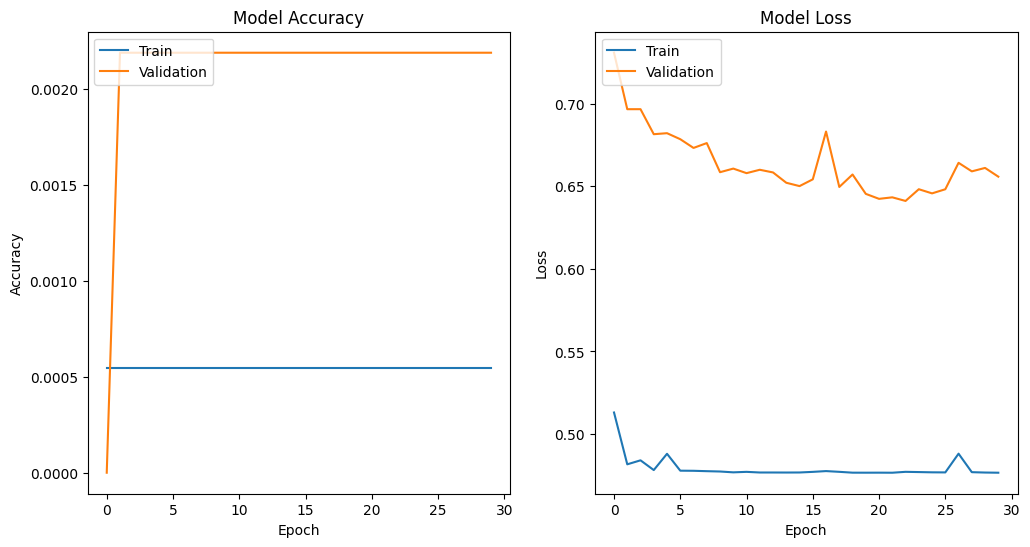

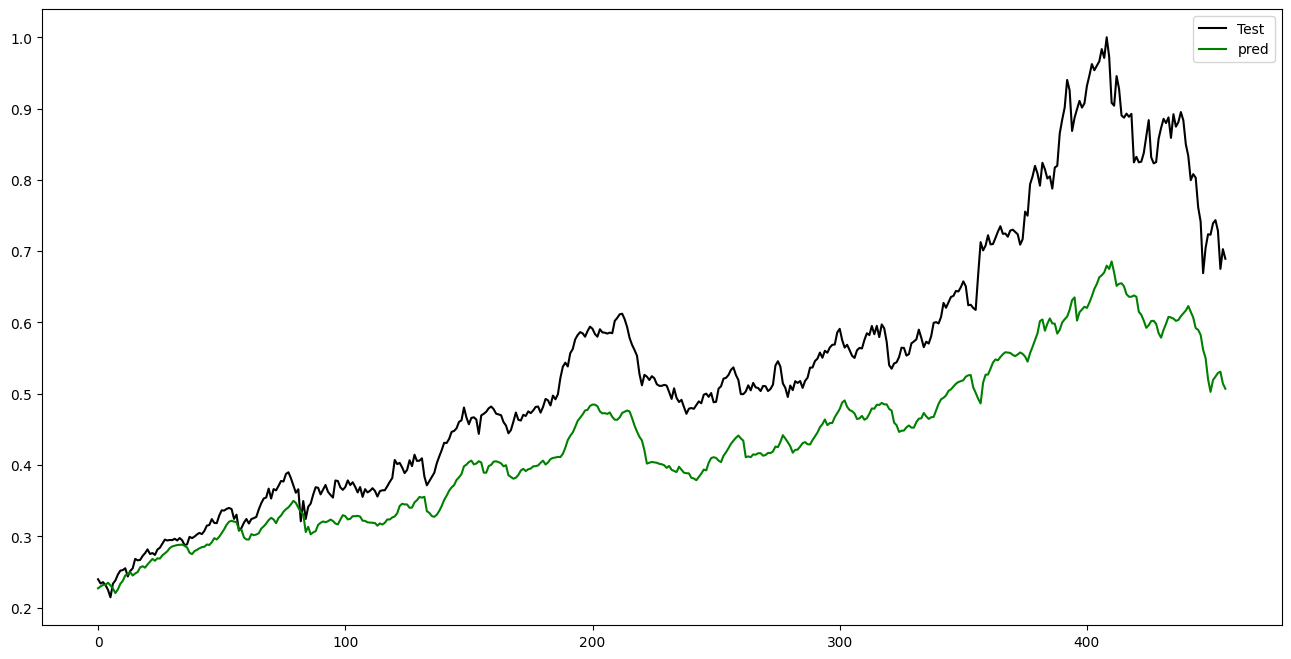

############################################################################
  Model Setup:
                    Name: ADM_F10_L150
             LSTM_Layers: 150
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: ADM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 10
  Result Data:
             mean_abs_err =0.9315344079499293
             mean_sqr_err =0.9053507590980918
        root_mean_sqr_err =0.9514992165514861
           pred_diff_mean =-0.8329455455364725
      pred_diff_bias_mean =1.8329455455364725
    pred_correctness_mean =0.212253829321663



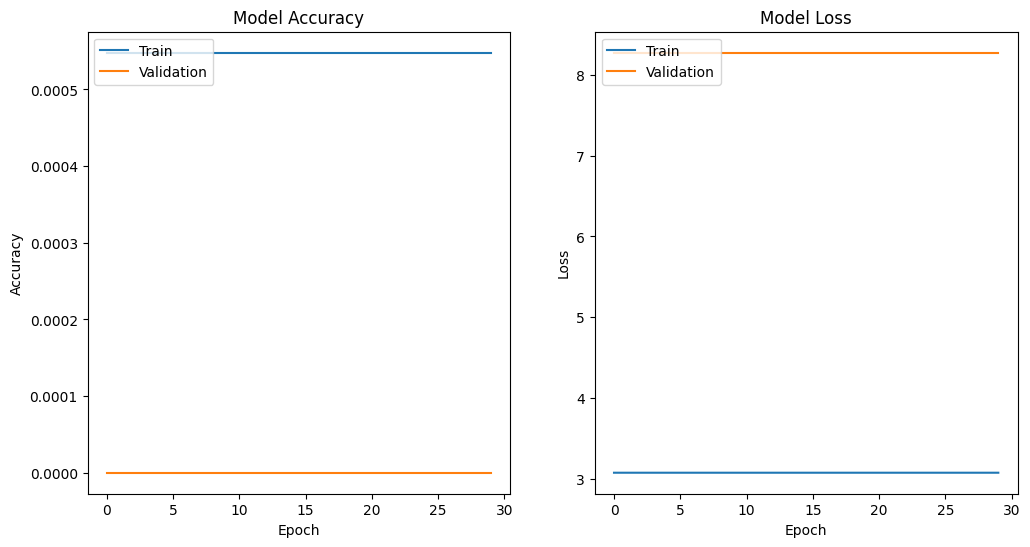

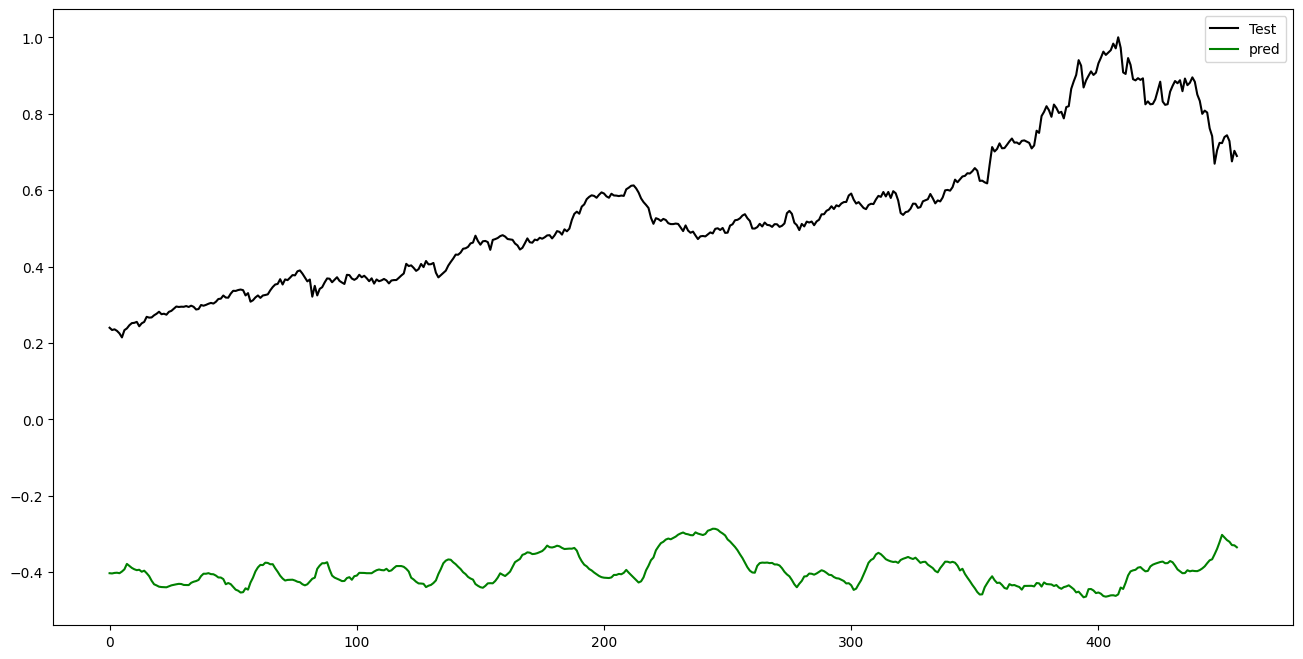

############################################################################
  Model Setup:
                    Name: ADM_F10_L250
             LSTM_Layers: 250
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: ADM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 10
  Result Data:
             mean_abs_err =5.133852837440338
             mean_sqr_err =26.481952075154215
        root_mean_sqr_err =5.146061802500453
           pred_diff_mean =-9.60004464862592
      pred_diff_bias_mean =10.60004464862592
    pred_correctness_mean =0.212253829321663



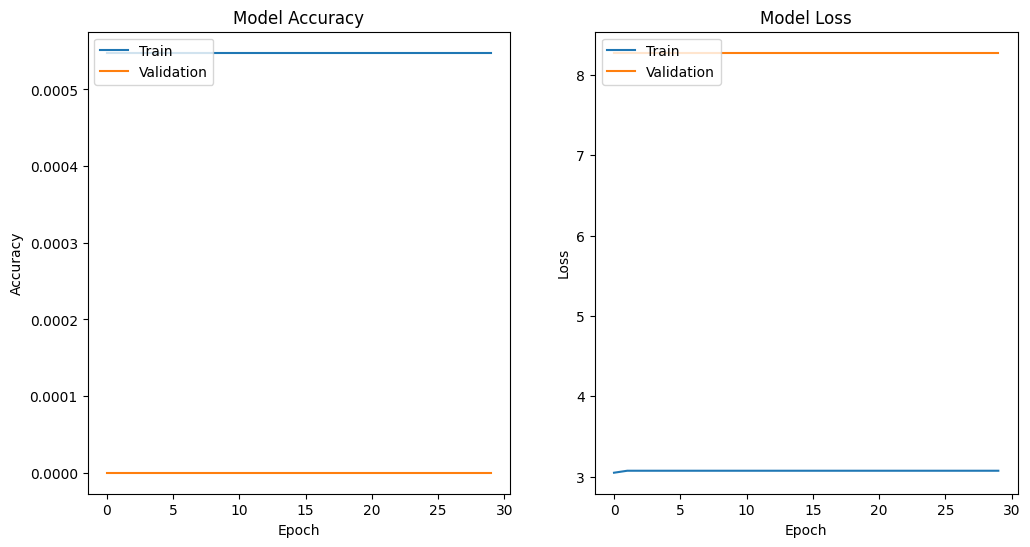

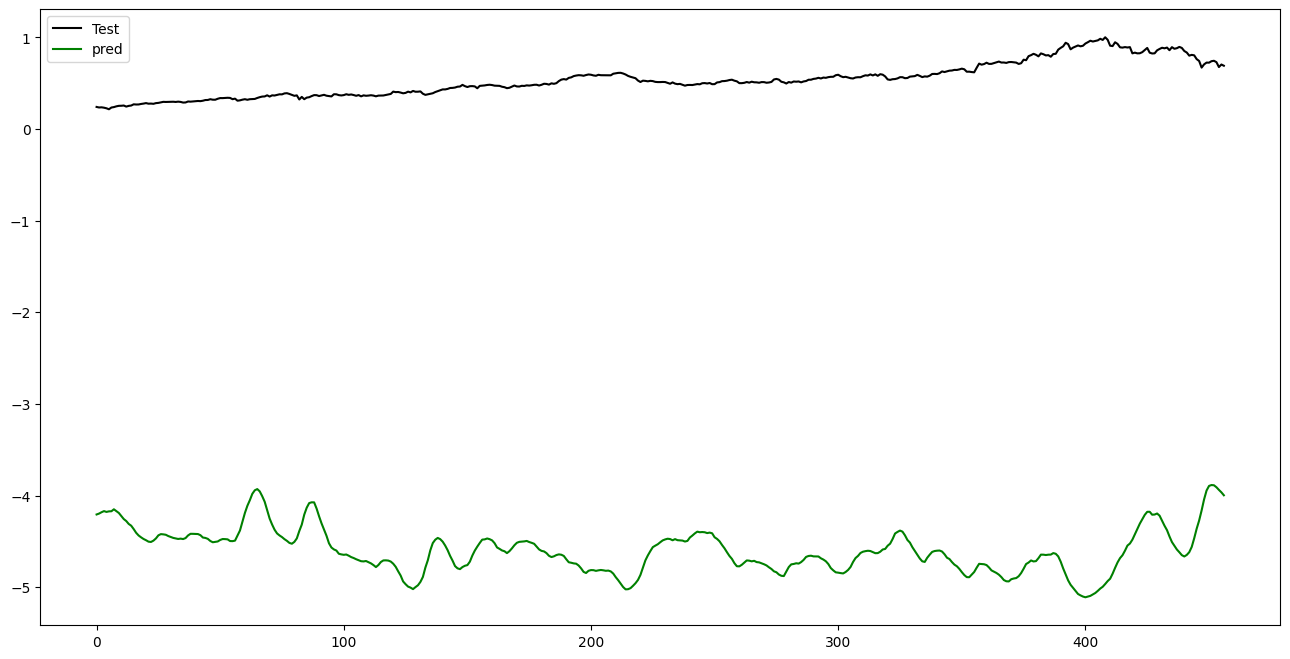

############################################################################
  Model Setup:
                    Name: ADM_F30_L50
             LSTM_Layers: 50
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: ADM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 30
  Result Data:
             mean_abs_err =0.08937949084380846
             mean_sqr_err =0.011847311063383471
        root_mean_sqr_err =0.10884535388974337
           pred_diff_mean =0.8540683923621954
      pred_diff_bias_mean =0.14593160763780444
    pred_correctness_mean =0.5938189845474614



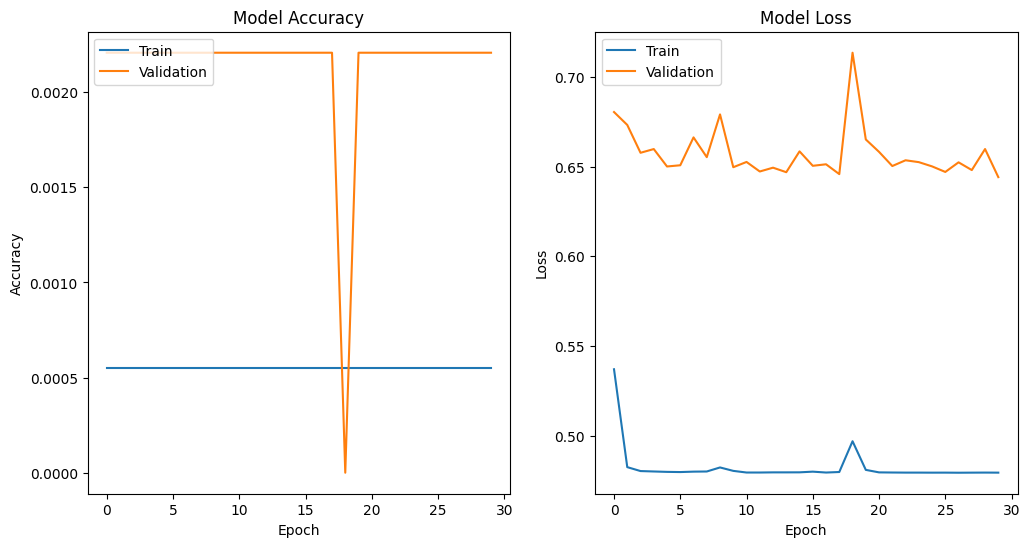

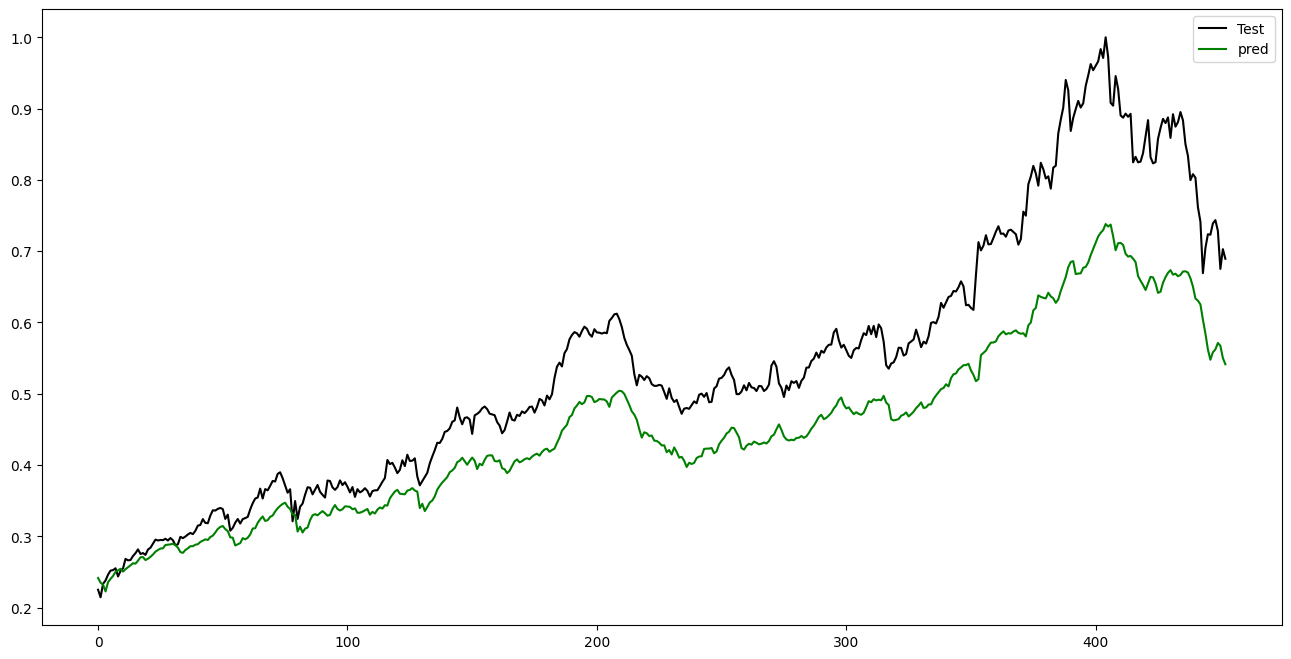

############################################################################
  Model Setup:
                    Name: ADM_F30_L150
             LSTM_Layers: 150
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: ADM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 30
  Result Data:
             mean_abs_err =0.07667916862184242
             mean_sqr_err =0.010158895834035061
        root_mean_sqr_err =0.10079134801179643
           pred_diff_mean =0.8819792055743263
      pred_diff_bias_mean =0.11802079442567381
    pred_correctness_mean =0.6843267108167771



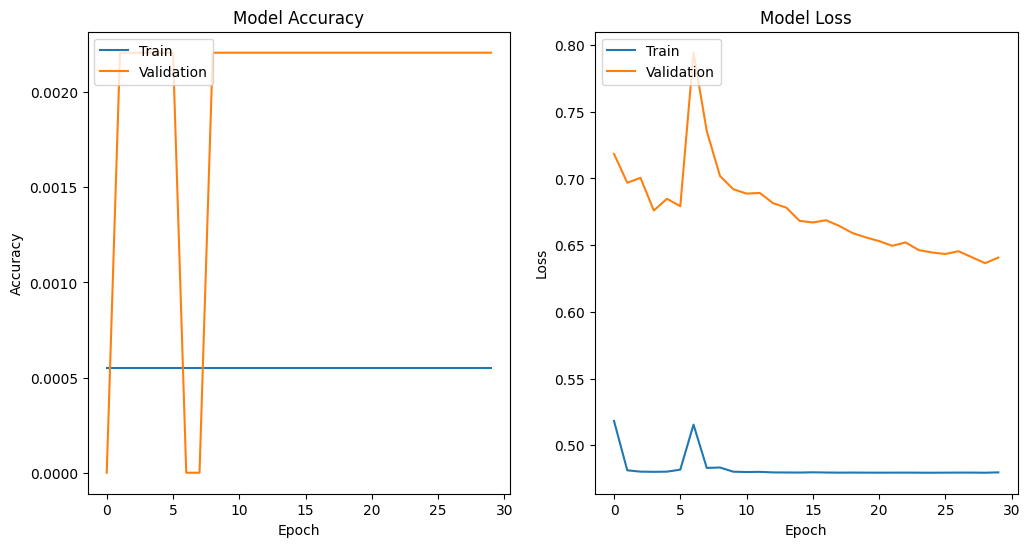

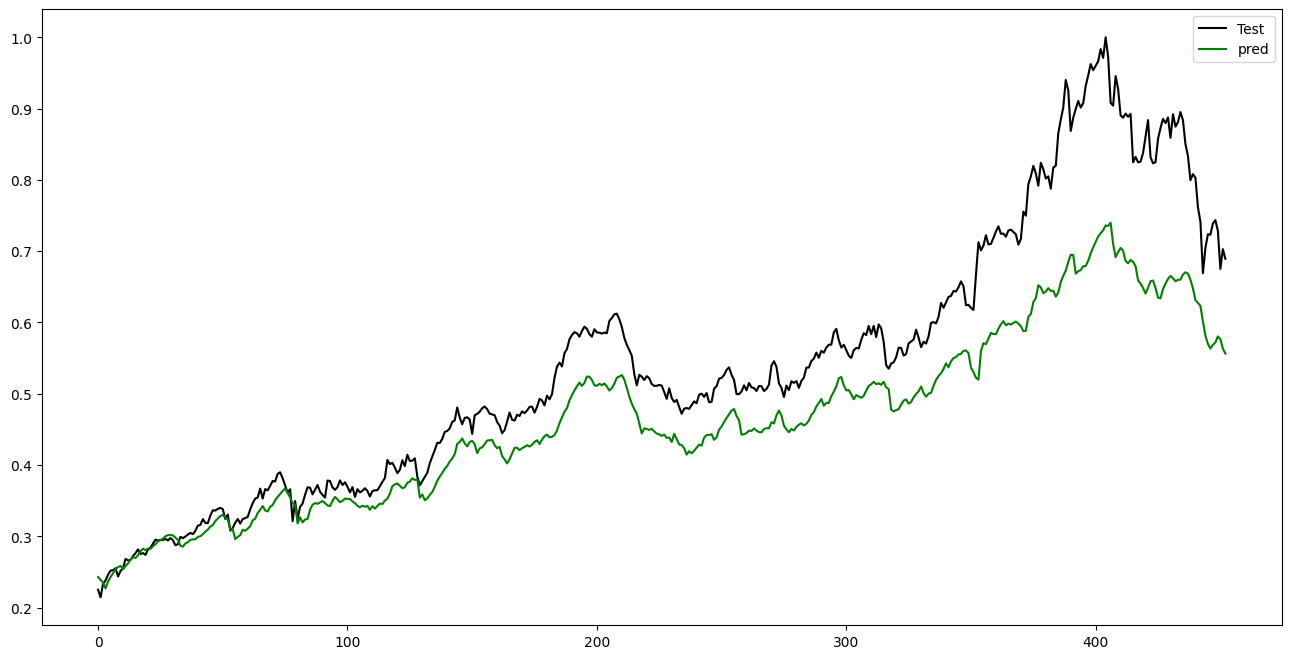

############################################################################
  Model Setup:
                    Name: ADM_F30_L250
             LSTM_Layers: 250
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: ADM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 30
  Result Data:
             mean_abs_err =0.9211935205697056
             mean_sqr_err =0.8907744237729446
        root_mean_sqr_err =0.9438084677374666
           pred_diff_mean =-0.7802865424641688
      pred_diff_bias_mean =1.7802865424641687
    pred_correctness_mean =0.17439293598233996



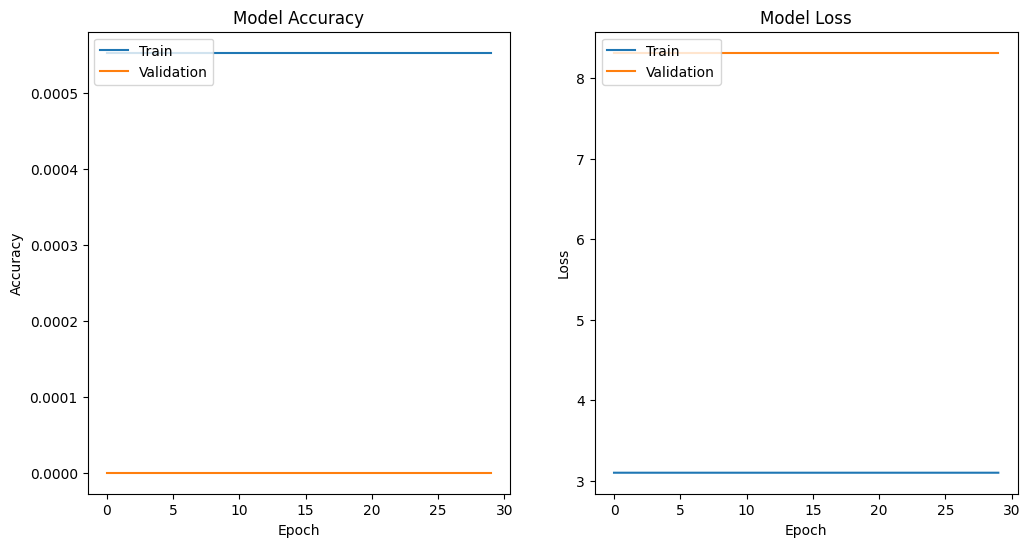

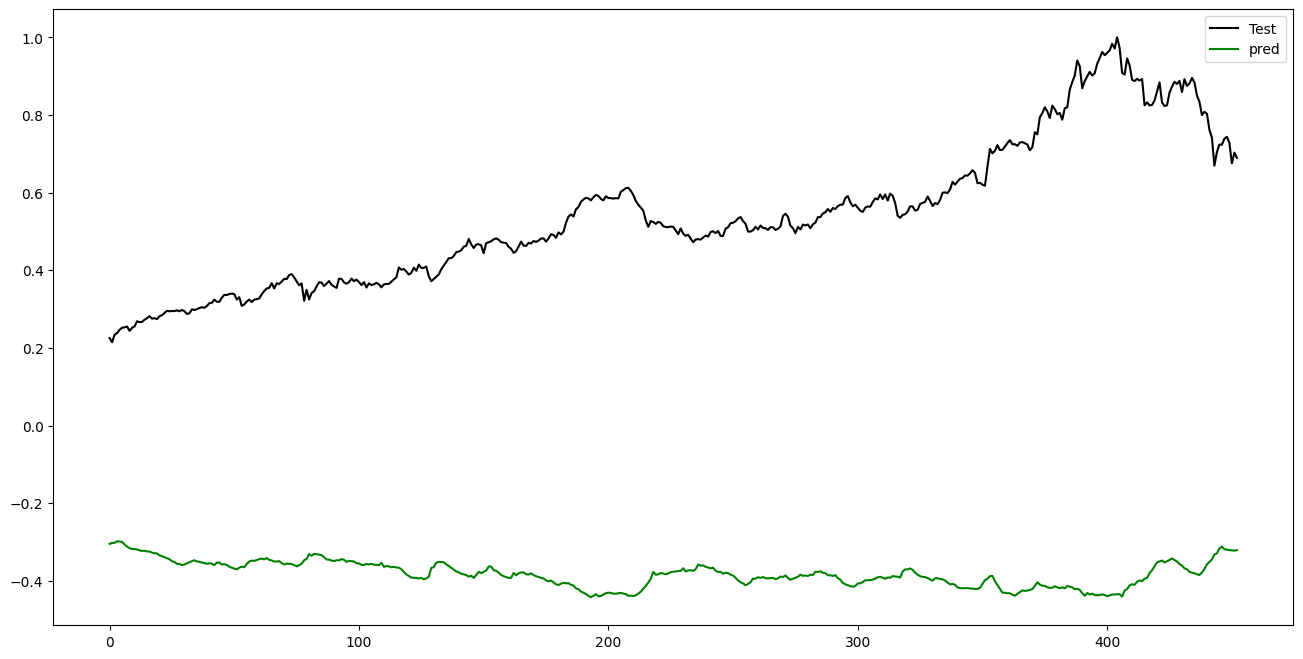

############################################################################
  Model Setup:
                    Name: ADM_F50_L50
             LSTM_Layers: 50
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: ADM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 50
  Result Data:
             mean_abs_err =0.09196551429378728
             mean_sqr_err =0.012491195037670568
        root_mean_sqr_err =0.11176401494967228
           pred_diff_mean =0.8501923300292872
      pred_diff_bias_mean =0.14980766997071288
    pred_correctness_mean =0.688195991091314



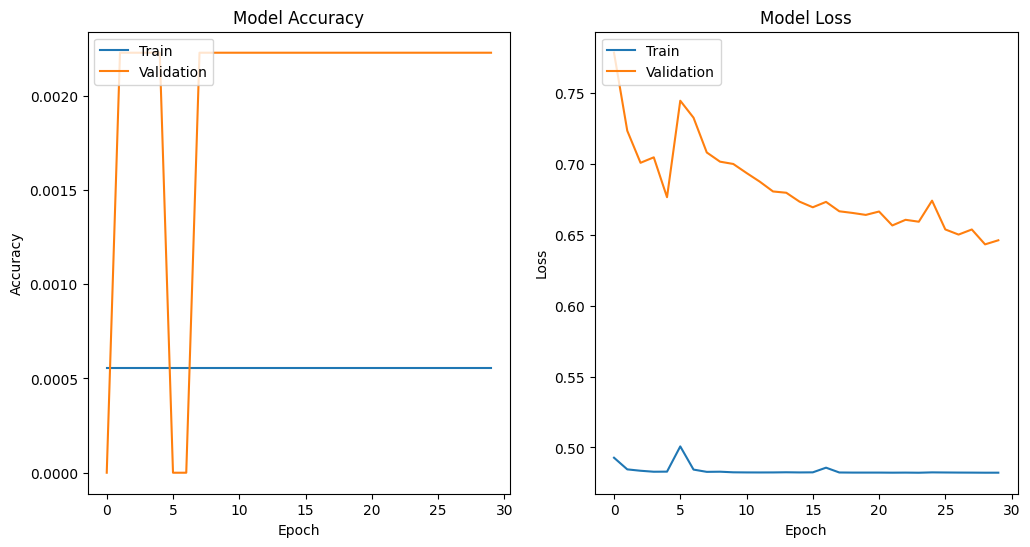

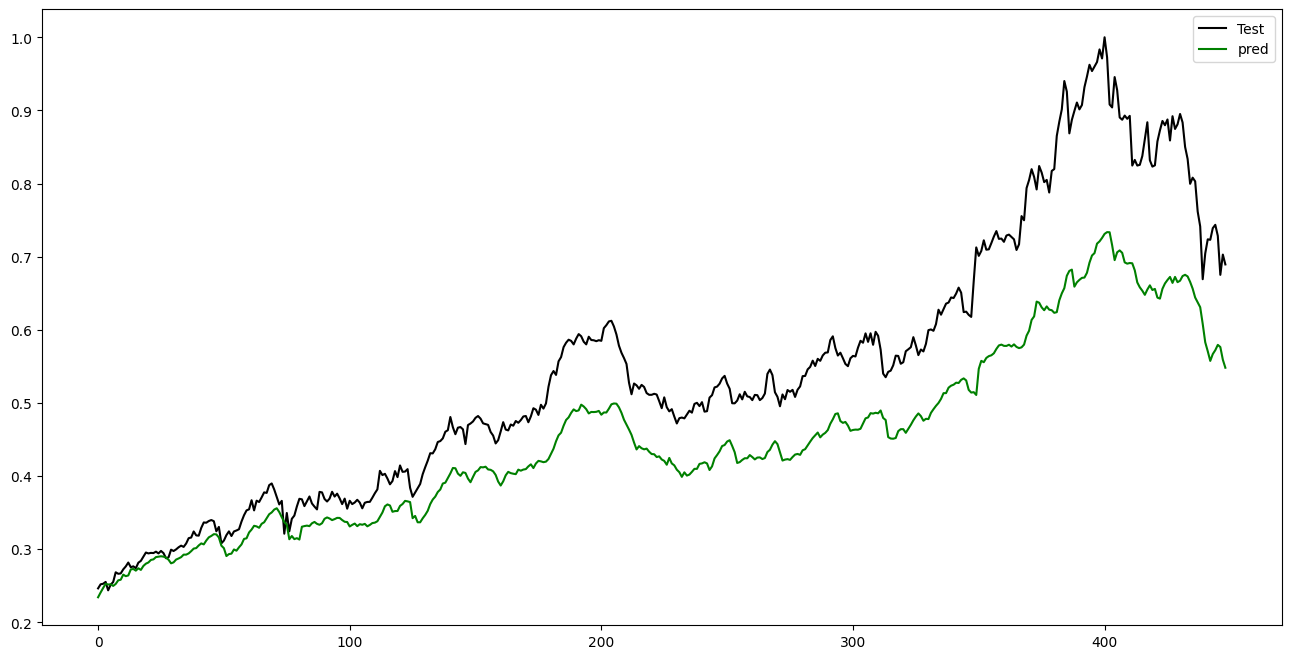

############################################################################
  Model Setup:
                    Name: ADM_F50_L150
             LSTM_Layers: 150
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: ADM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 50
  Result Data:
             mean_abs_err =0.10636089292714278
             mean_sqr_err =0.016118608650275368
        root_mean_sqr_err =0.12695908258283597
           pred_diff_mean =0.8228370295300206
      pred_diff_bias_mean =0.17716297046997947
    pred_correctness_mean =0.6391982182628062



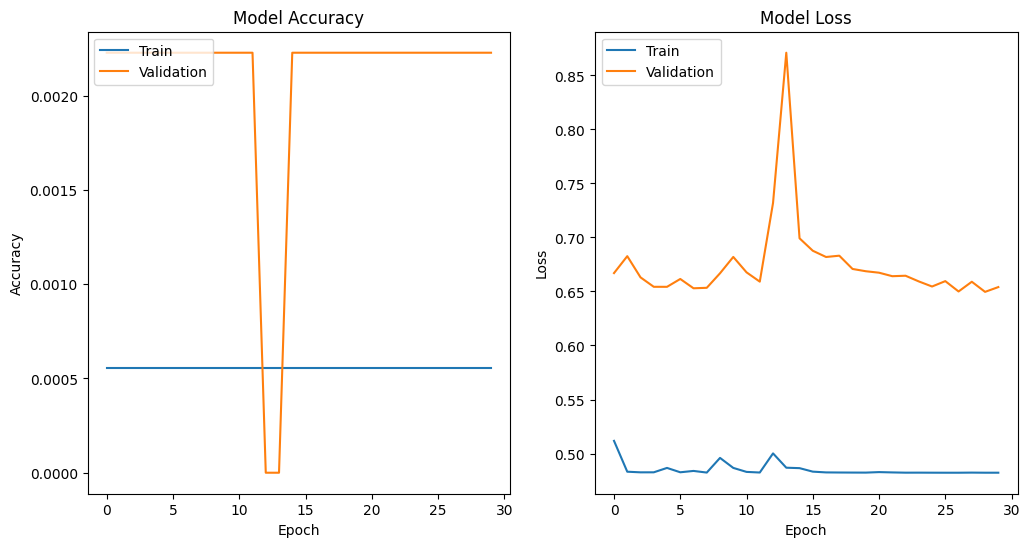

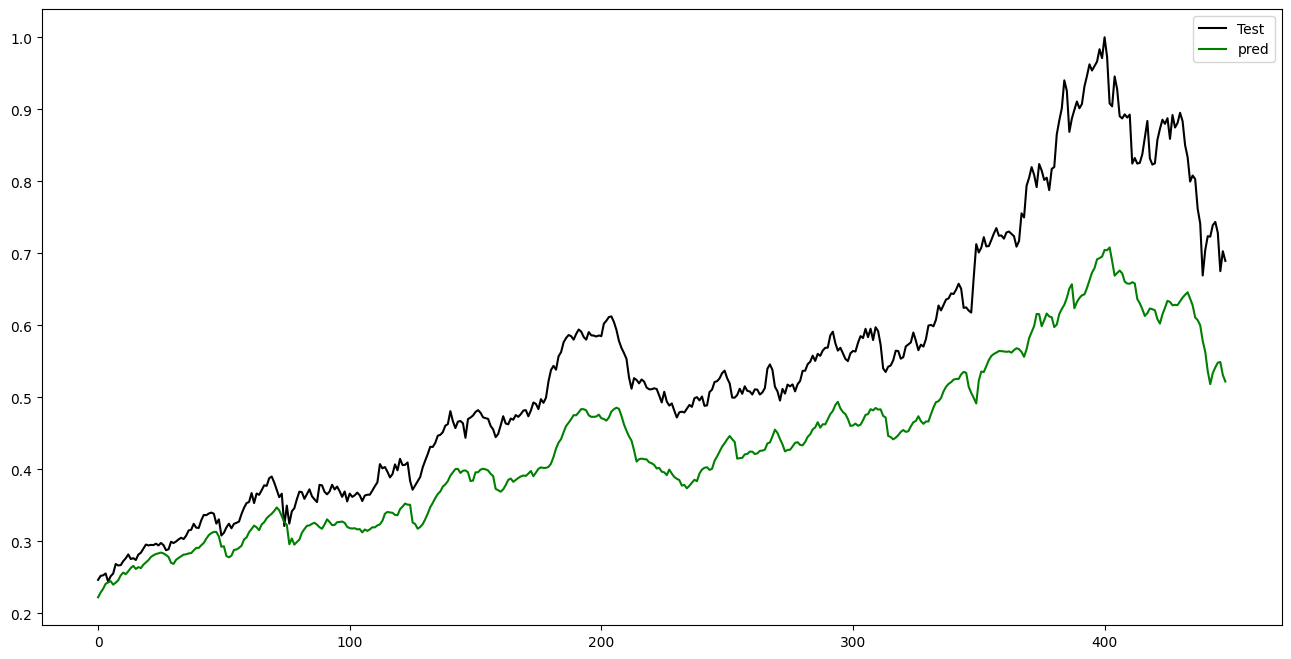

############################################################################
  Model Setup:
                    Name: ADM_F50_L250
             LSTM_Layers: 250
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: ADM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 50
  Result Data:
             mean_abs_err =1.0134299946720087
             mean_sqr_err =1.079248145895832
        root_mean_sqr_err =1.0388686855882374
           pred_diff_mean =-0.941394163257528
      pred_diff_bias_mean =1.9413941632575278
    pred_correctness_mean =0.12026726057906459



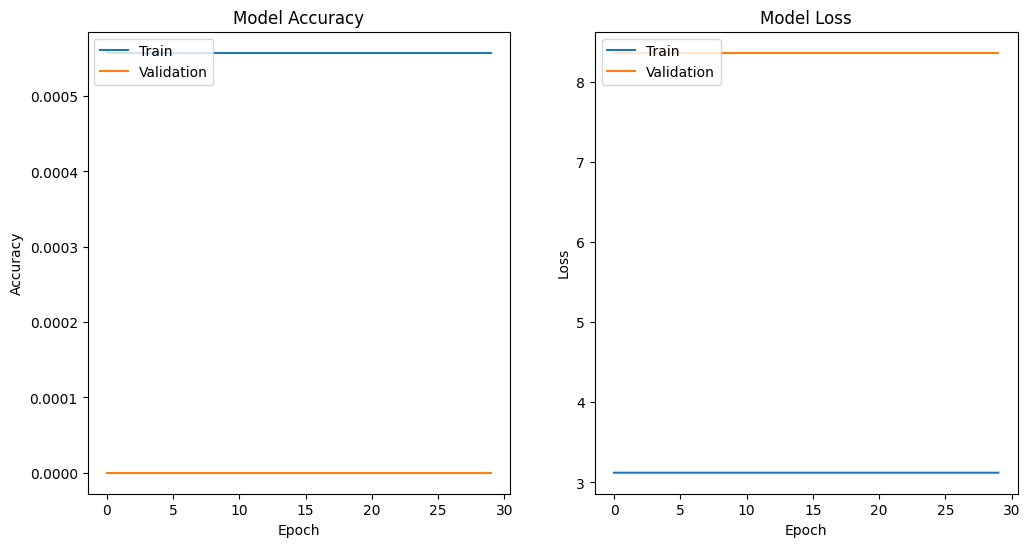

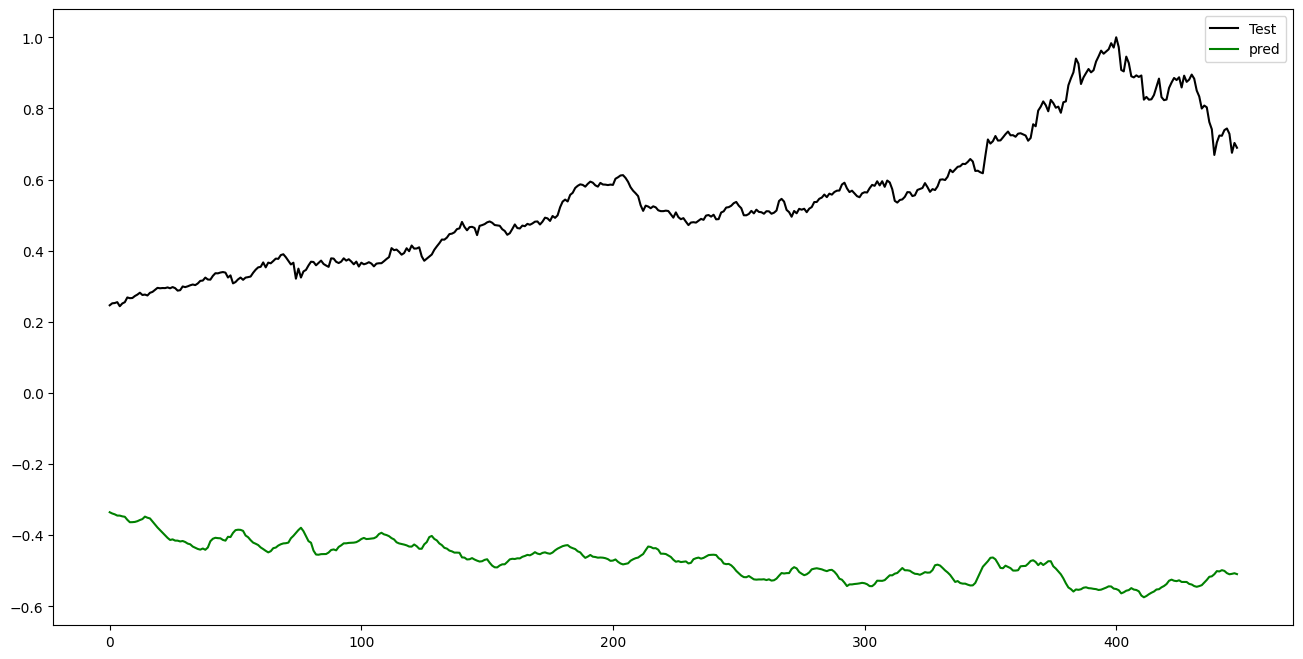

############################################################################
  Model Setup:
                    Name: MSI_F10_L50
             LSTM_Layers: 50
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: MSI
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 10
  Result Data:
             mean_abs_err =0.0670996002880021
             mean_sqr_err =0.007310571699171374
        root_mean_sqr_err =0.0855018812610072
           pred_diff_mean =0.9193387276213995
      pred_diff_bias_mean =0.08066127237860056
    pred_correctness_mean =0.5470459518599562



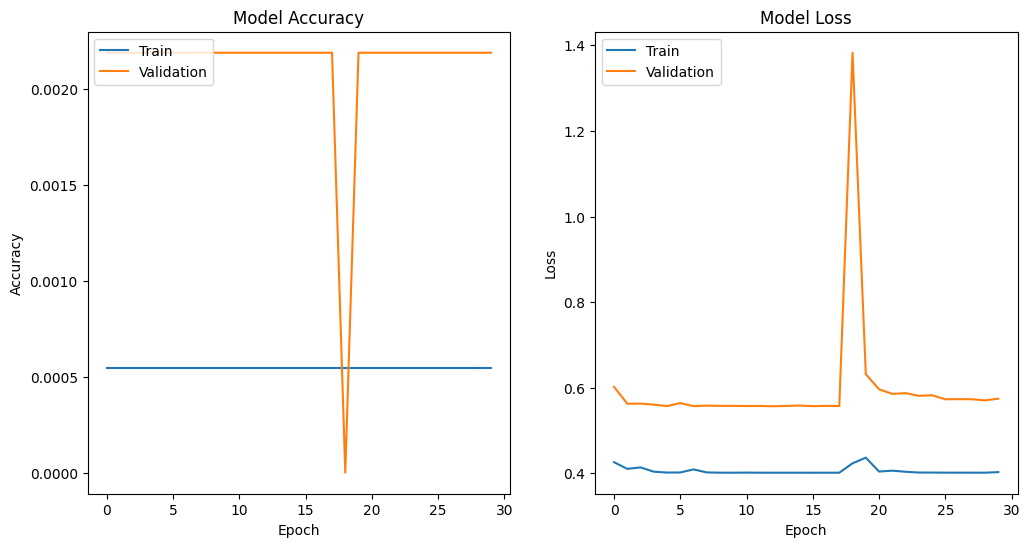

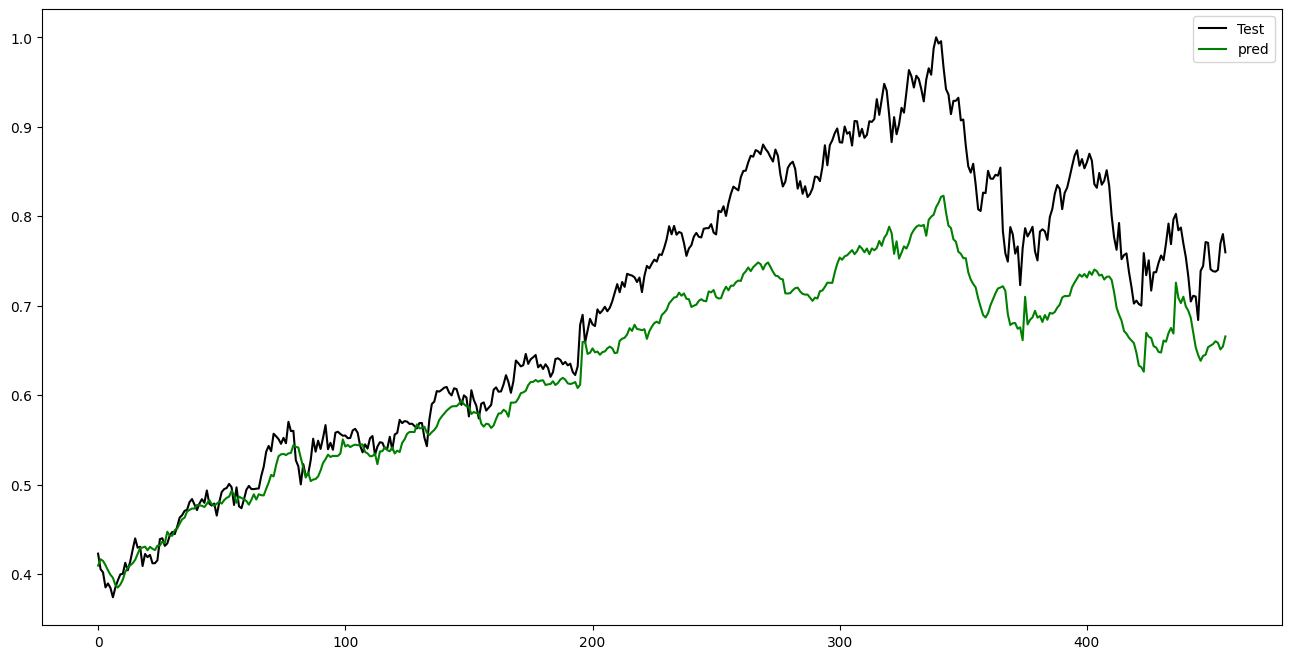

############################################################################
  Model Setup:
                    Name: MSI_F10_L150
             LSTM_Layers: 150
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: MSI
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 10
  Result Data:
             mean_abs_err =0.01885430707382629
             mean_sqr_err =0.0006431939825476517
        root_mean_sqr_err =0.02536126934022924
           pred_diff_mean =0.9865911483410945
      pred_diff_bias_mean =0.013408851658905504
    pred_correctness_mean =0.8227571115973742



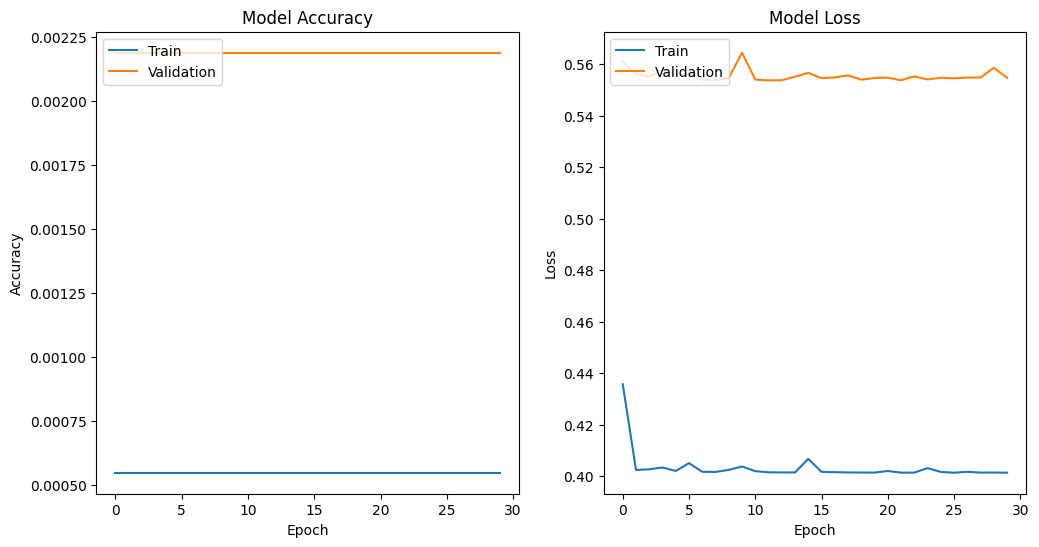

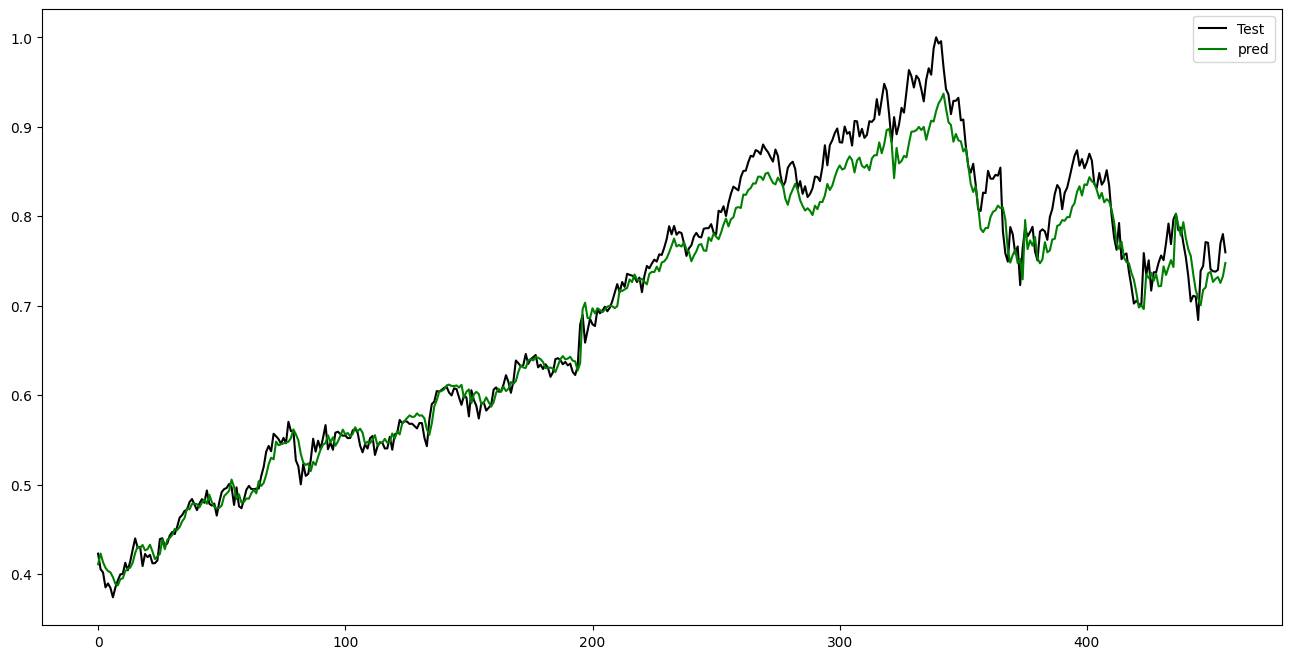

############################################################################
  Model Setup:
                    Name: MSI_F10_L250
             LSTM_Layers: 250
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: MSI
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 10
  Result Data:
             mean_abs_err =0.7970963752793858
             mean_sqr_err =0.6520952064947688
        root_mean_sqr_err =0.8075241213083166
           pred_diff_mean =-0.1682968851521498
      pred_diff_bias_mean =1.1682968851521498
    pred_correctness_mean =0.3063457330415755



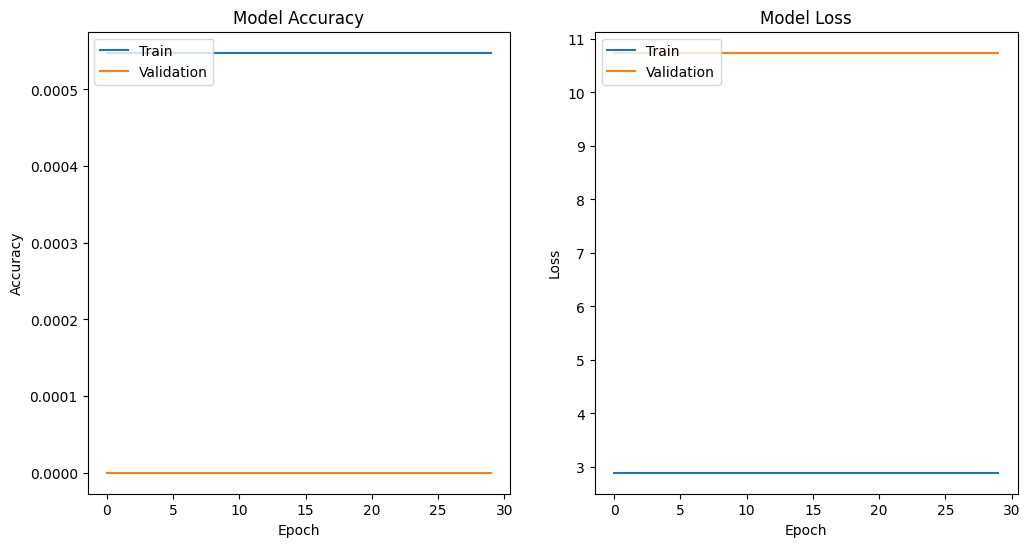

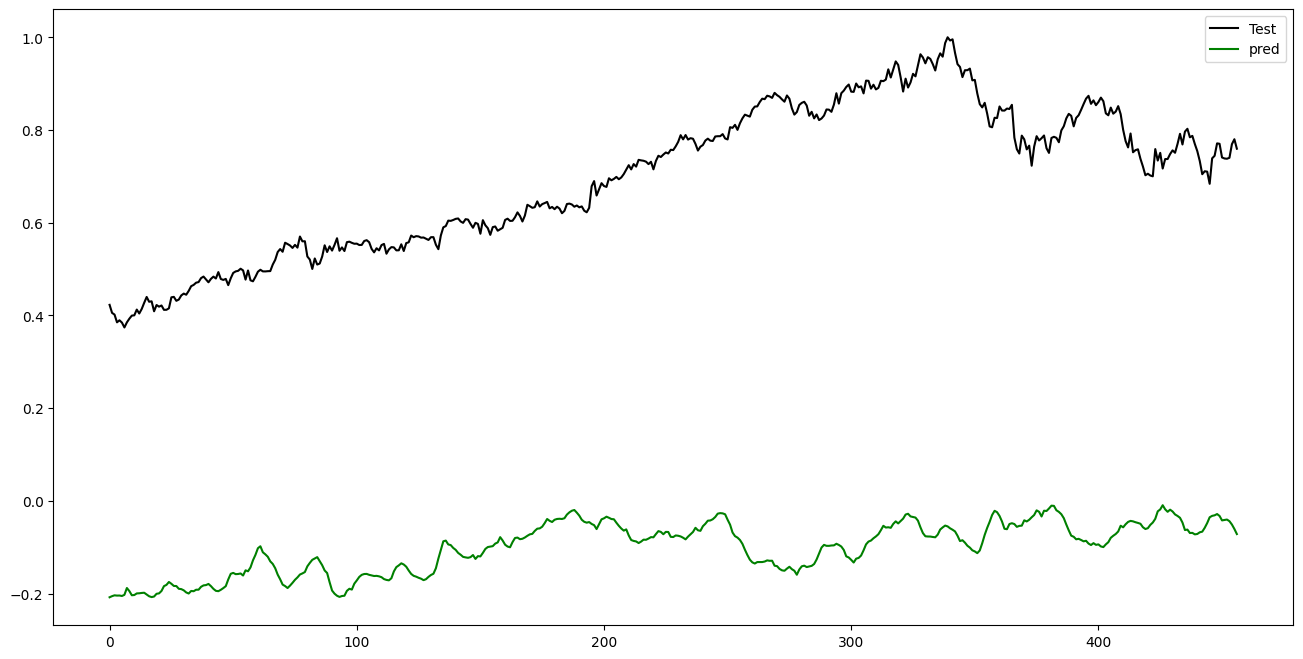

############################################################################
  Model Setup:
                    Name: MSI_F30_L50
             LSTM_Layers: 50
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: MSI
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 30
  Result Data:
             mean_abs_err =0.031326989765416056
             mean_sqr_err =0.001749465650485791
        root_mean_sqr_err =0.04182661414082894
           pred_diff_mean =0.9696666910113076
      pred_diff_bias_mean =0.030333308988692277
    pred_correctness_mean =0.82560706401766



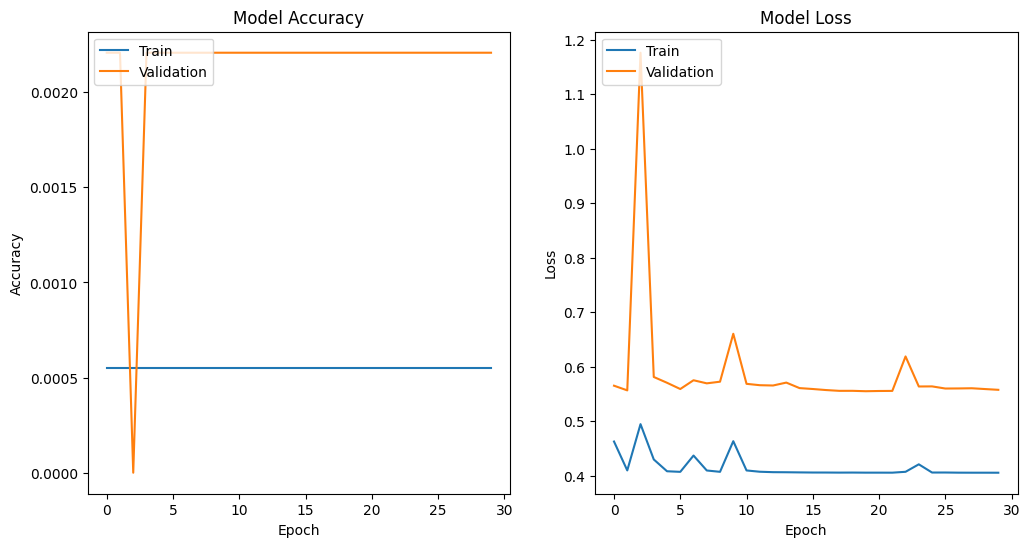

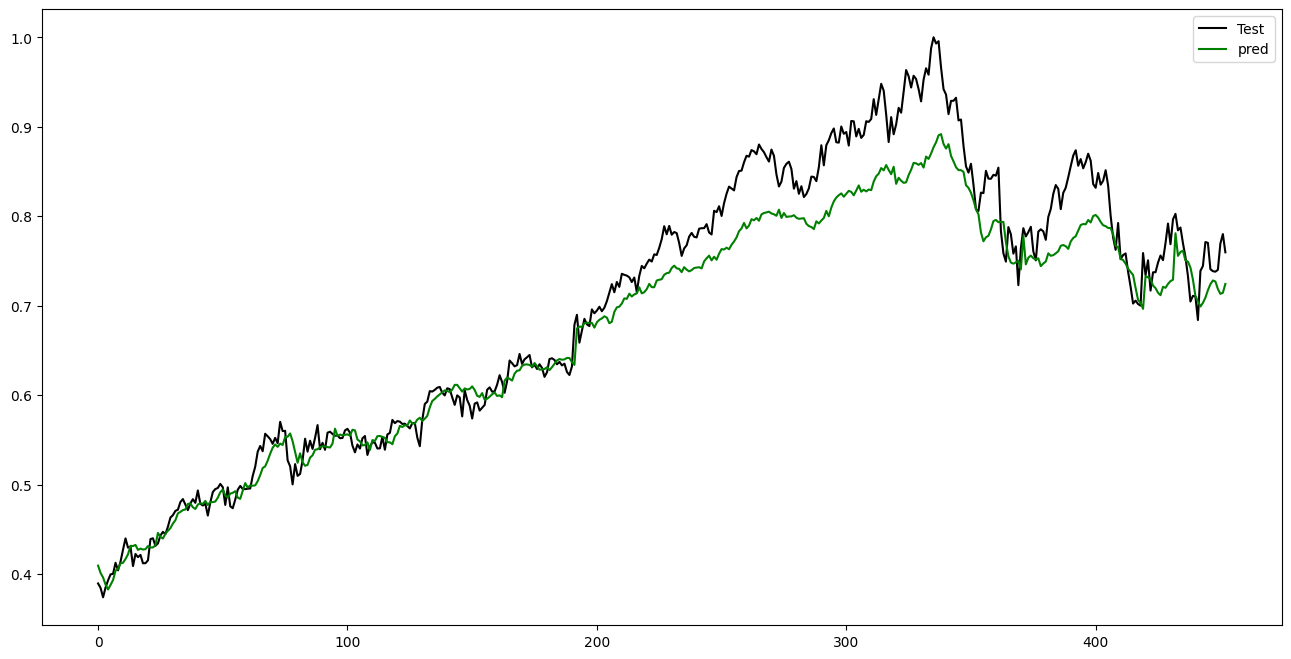

############################################################################
  Model Setup:
                    Name: MSI_F30_L150
             LSTM_Layers: 150
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: MSI
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 30
  Result Data:
             mean_abs_err =1.0447095892466567
             mean_sqr_err =1.1246396220043962
        root_mean_sqr_err =1.0604902743563451
           pred_diff_mean =-0.5126470732408338
      pred_diff_bias_mean =1.5126470732408337
    pred_correctness_mean =0.2229580573951435



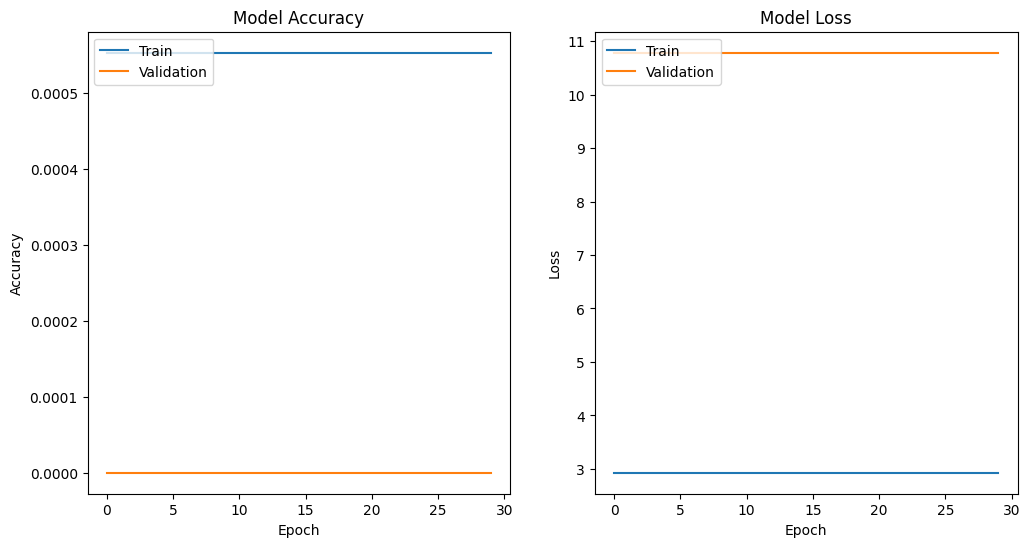

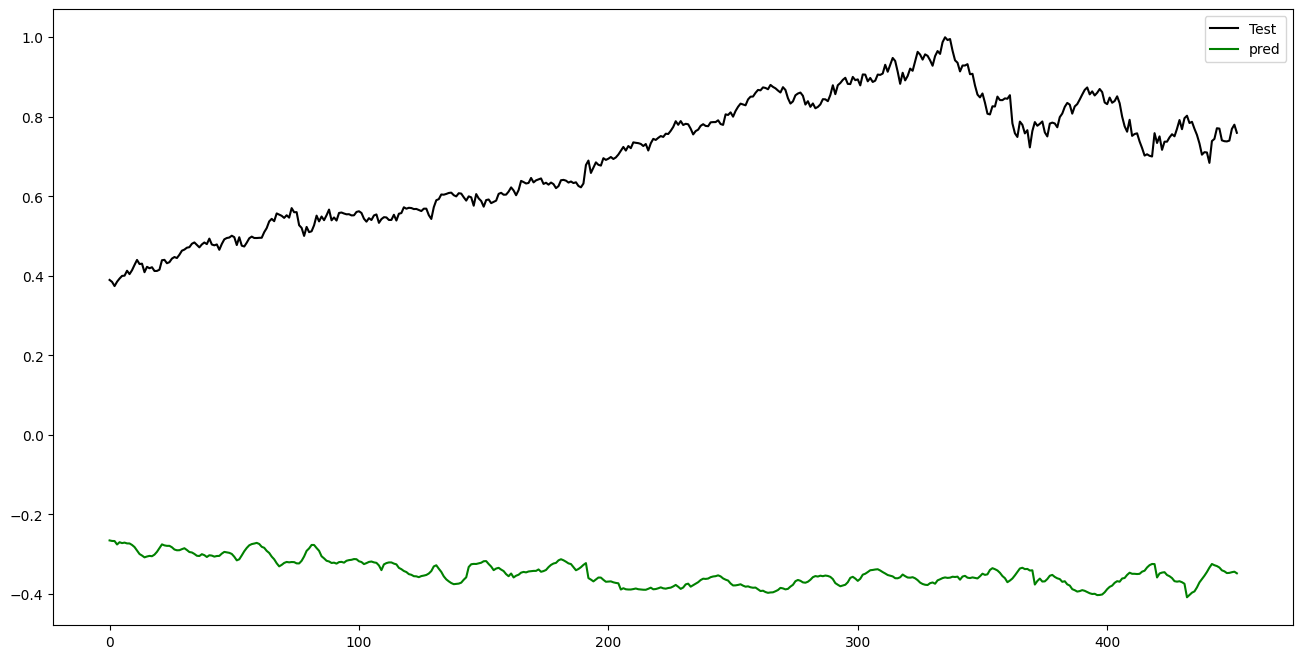

############################################################################
  Model Setup:
                    Name: MSI_F30_L250
             LSTM_Layers: 250
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: MSI
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 30
  Result Data:
             mean_abs_err =0.06917399270819219
             mean_sqr_err =0.008600946870616593
        root_mean_sqr_err =0.0927412899986656
           pred_diff_mean =0.9258418704949369
      pred_diff_bias_mean =0.07415812950506297
    pred_correctness_mean =0.6600441501103753



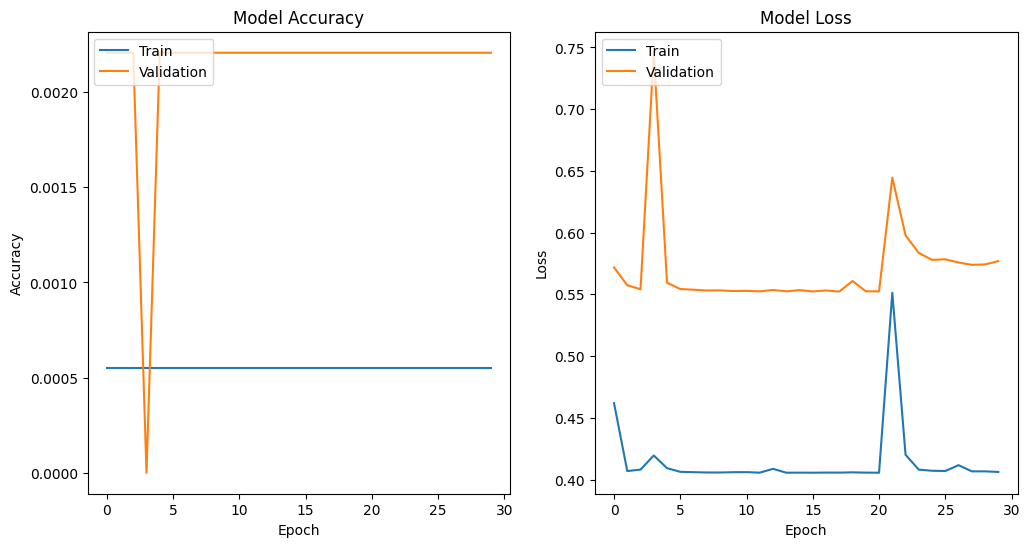

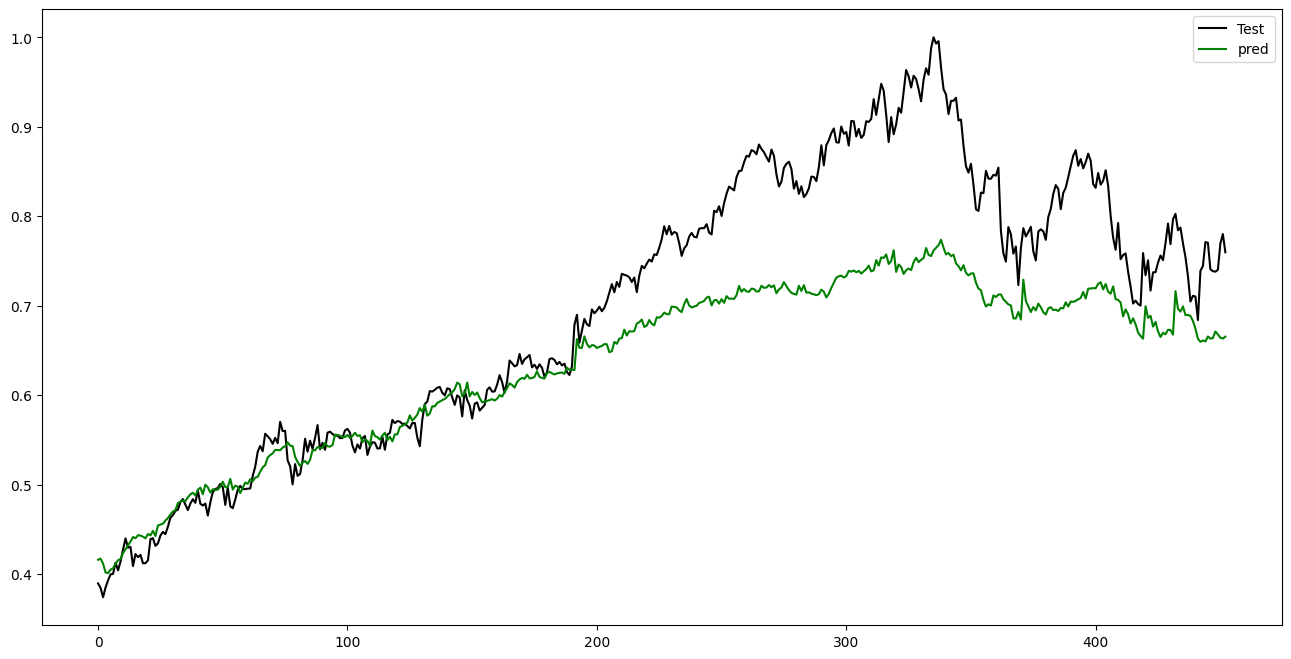

############################################################################
  Model Setup:
                    Name: MSI_F50_L50
             LSTM_Layers: 50
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: MSI
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 50
  Result Data:
             mean_abs_err =0.027304635504236126
             mean_sqr_err =0.0013308003645781008
        root_mean_sqr_err =0.03648013657565033
           pred_diff_mean =0.9707801108129279
      pred_diff_bias_mean =0.029219889187072086
    pred_correctness_mean =0.9265033407572383



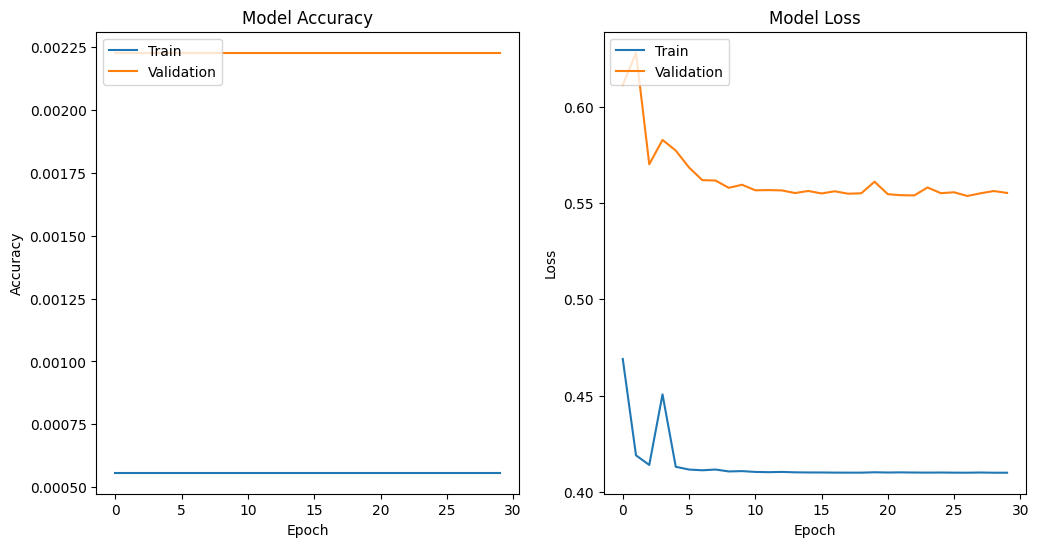

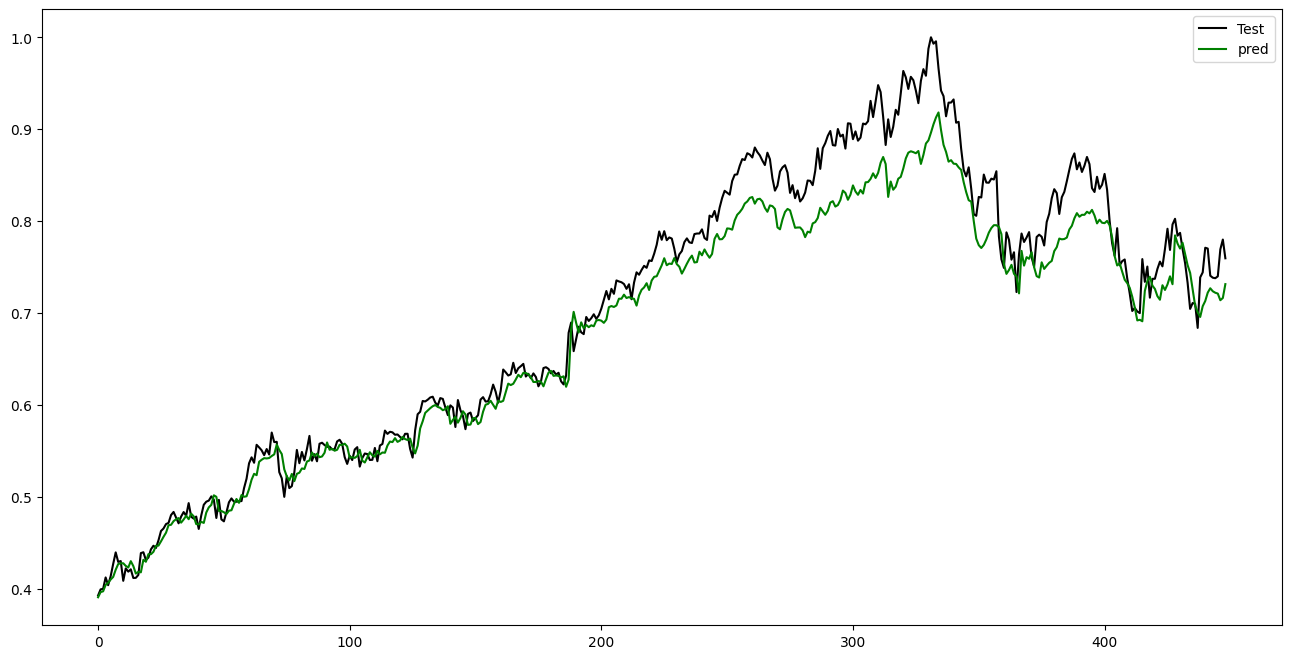

############################################################################
  Model Setup:
                    Name: MSI_F50_L150
             LSTM_Layers: 150
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: MSI
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 50
  Result Data:
             mean_abs_err =0.057272350856716205
             mean_sqr_err =0.005722024944992424
        root_mean_sqr_err =0.07564406748048669
           pred_diff_mean =0.94791955232158
      pred_diff_bias_mean =0.052080447678420065
    pred_correctness_mean =0.8151447661469933



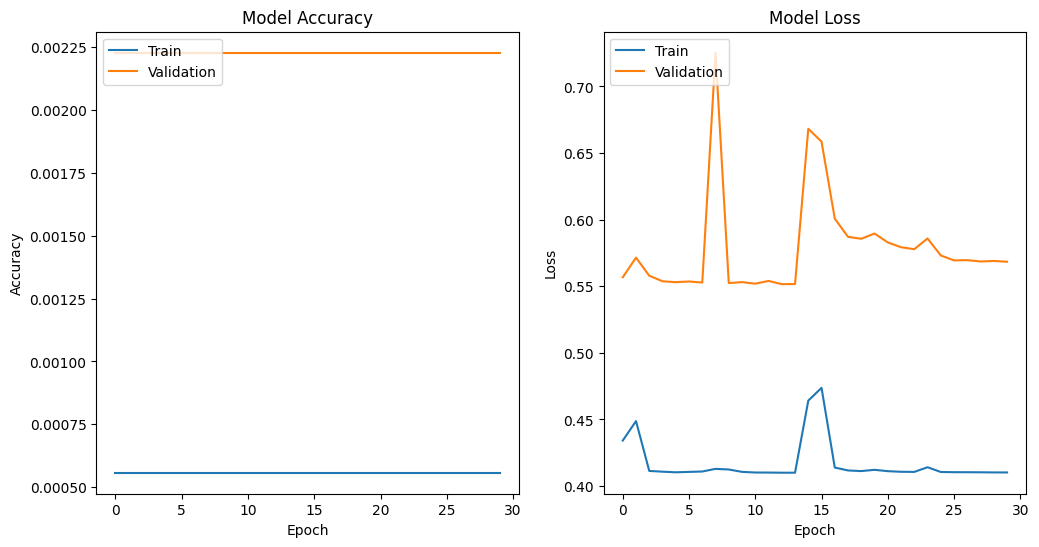

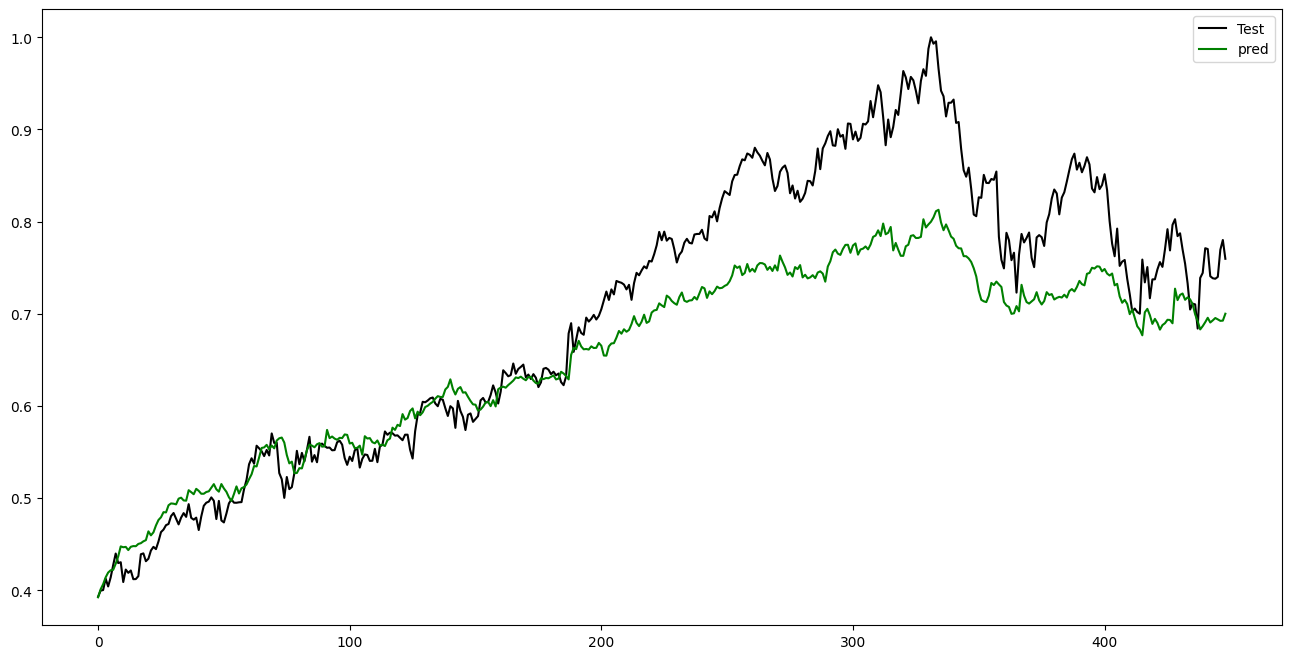

############################################################################
  Model Setup:
                    Name: MSI_F50_L250
             LSTM_Layers: 250
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: MSI
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 50
  Result Data:
             mean_abs_err =4.496579836090775
             mean_sqr_err =20.231724413967346
        root_mean_sqr_err =4.497968920965033
           pred_diff_mean =-5.722623407104753
      pred_diff_bias_mean =6.722623407104753
    pred_correctness_mean =0.22717149220489977



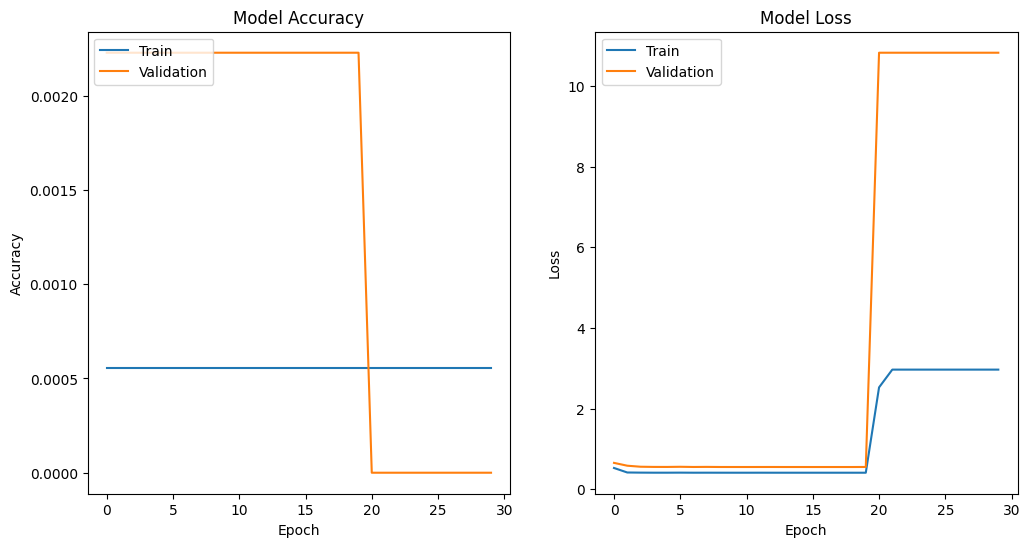

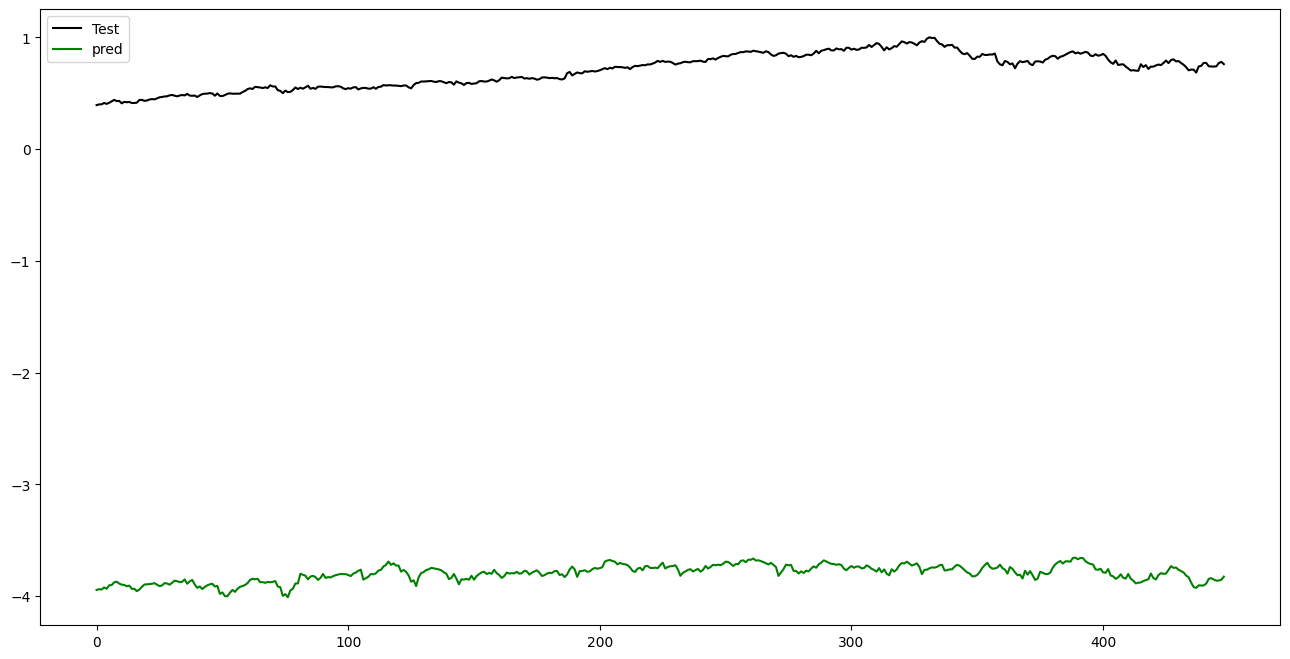

############################################################################
  Model Setup:
                    Name: XOM_F10_L50
             LSTM_Layers: 50
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: XOM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 10
  Result Data:
             mean_abs_err =0.06094623633407532
             mean_sqr_err =0.006164167614747321
        root_mean_sqr_err =0.07851221315659954
           pred_diff_mean =0.9368858486074684
      pred_diff_bias_mean =0.06311415139253167
    pred_correctness_mean =0.6214442013129103



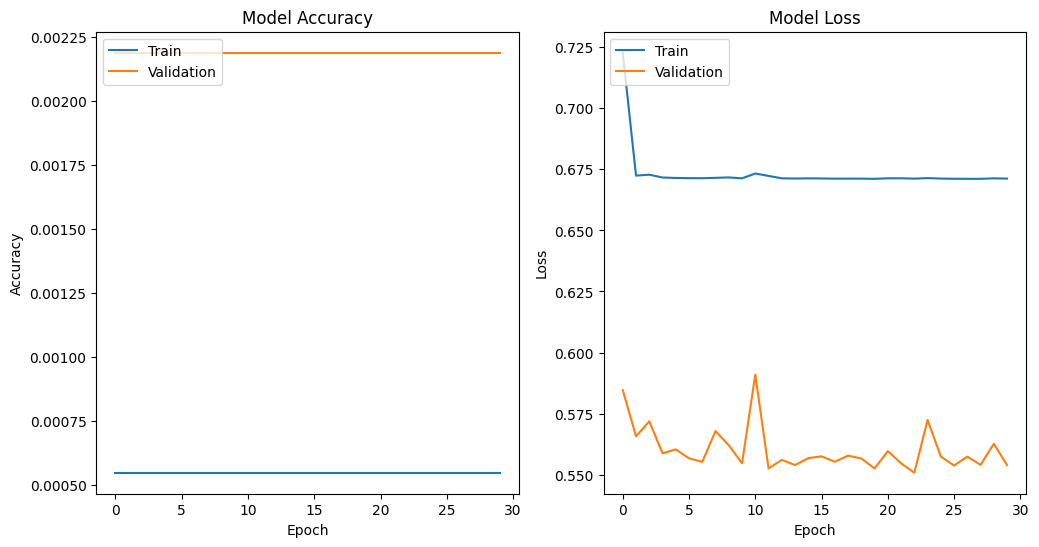

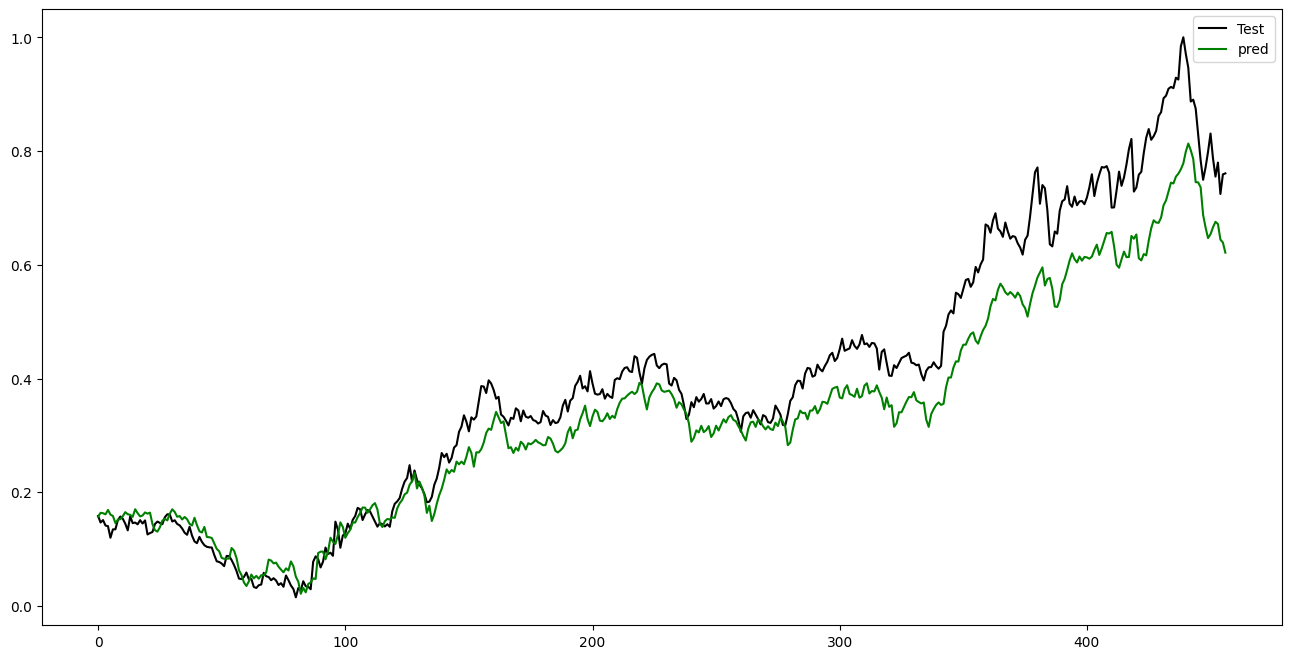

############################################################################
  Model Setup:
                    Name: XOM_F10_L150
             LSTM_Layers: 150
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: XOM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 10
  Result Data:
             mean_abs_err =0.0738255520560571
             mean_sqr_err =0.009402282616880173
        root_mean_sqr_err =0.09696536813151474
           pred_diff_mean =0.8782558538133072
      pred_diff_bias_mean =0.12174414618669295
    pred_correctness_mean =0.6280087527352297



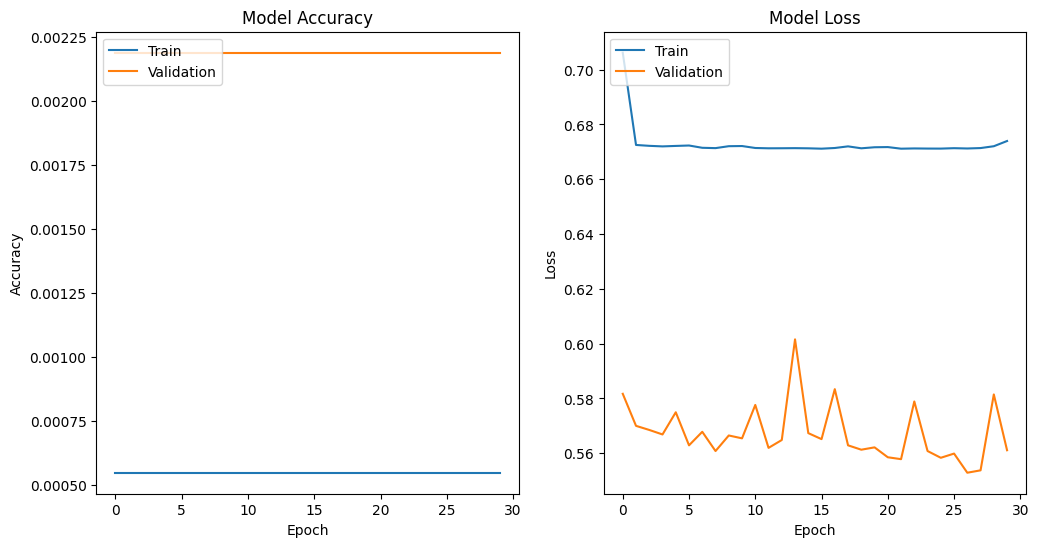

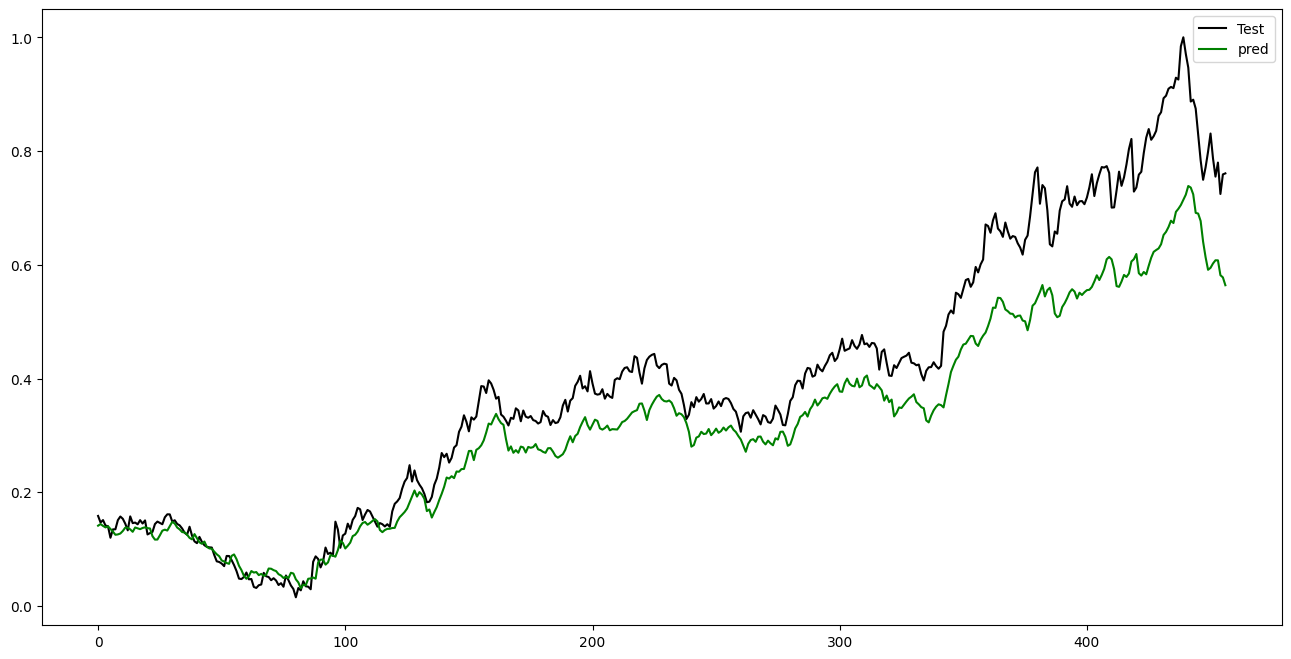

############################################################################
  Model Setup:
                    Name: XOM_F10_L250
             LSTM_Layers: 250
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: XOM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 10
  Result Data:
             mean_abs_err =0.05490210383990227
             mean_sqr_err =0.005712145379518201
        root_mean_sqr_err =0.075578736292149
           pred_diff_mean =1.1762887288802761
      pred_diff_bias_mean =-0.17628872888027602
    pred_correctness_mean =0.6192560175054704



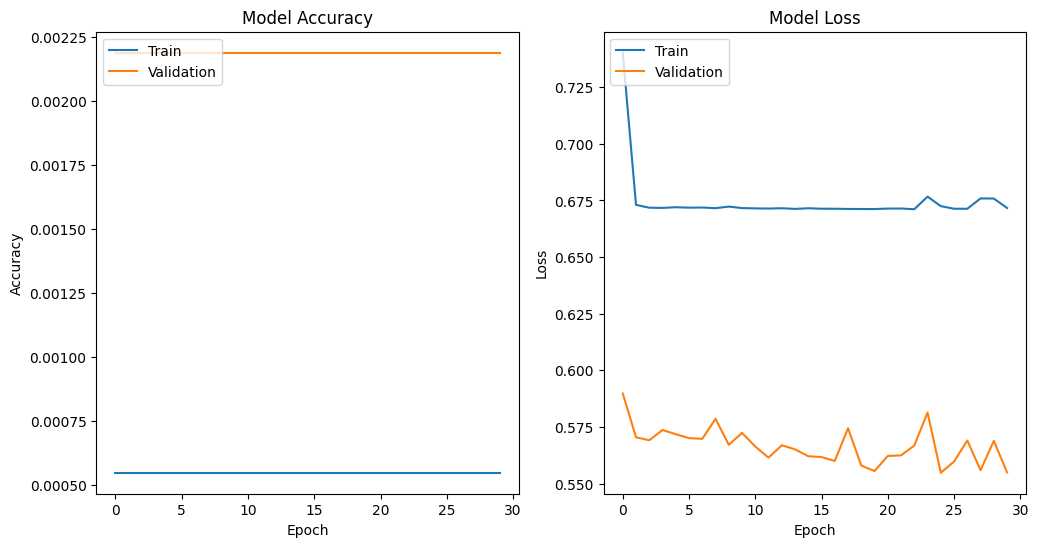

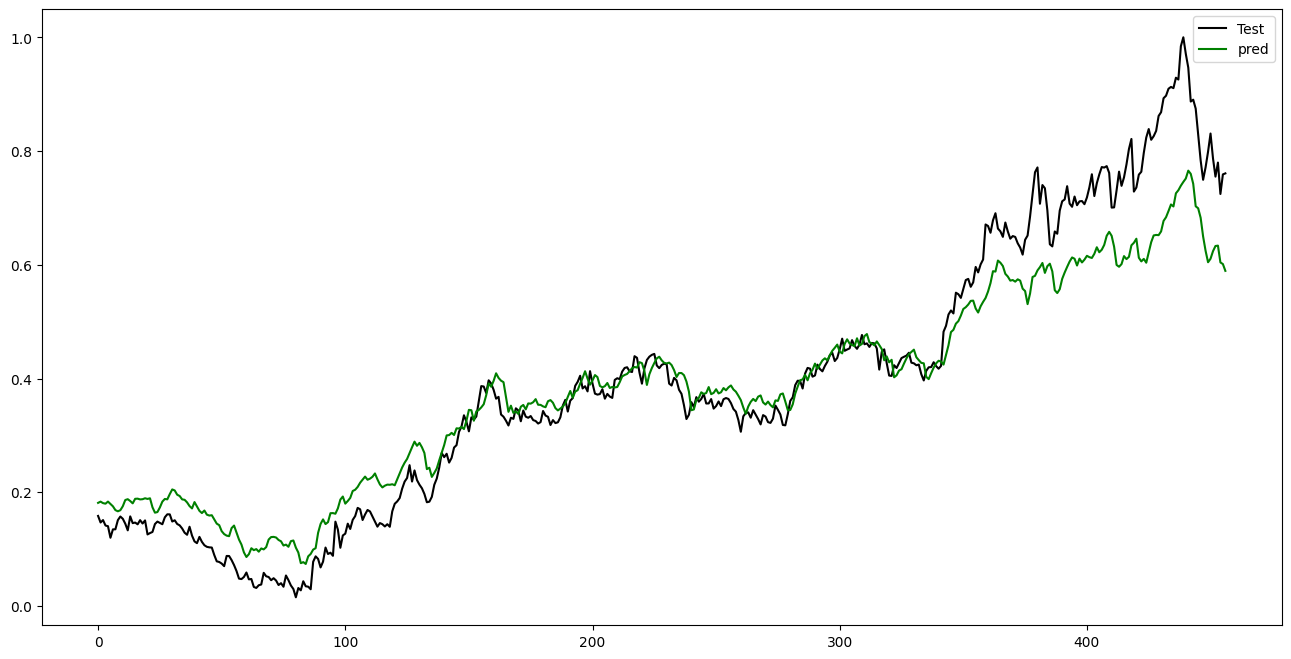

############################################################################
  Model Setup:
                    Name: XOM_F30_L50
             LSTM_Layers: 50
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: XOM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 30
  Result Data:
             mean_abs_err =0.09517742412859564
             mean_sqr_err =0.01403566349048271
        root_mean_sqr_err =0.11847220556097836
           pred_diff_mean =0.7760480469332841
      pred_diff_bias_mean =0.22395195306671586
    pred_correctness_mean =0.6070640176600441



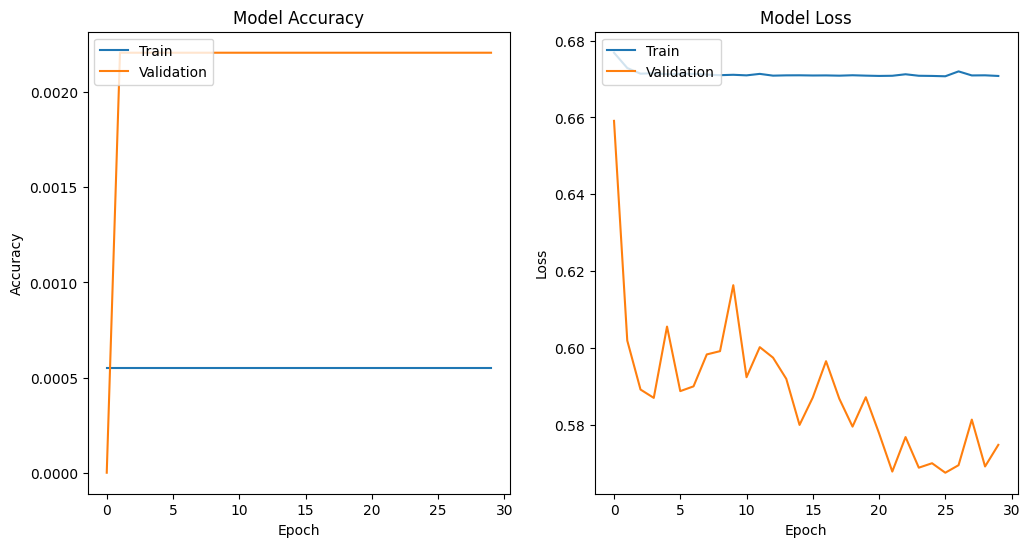

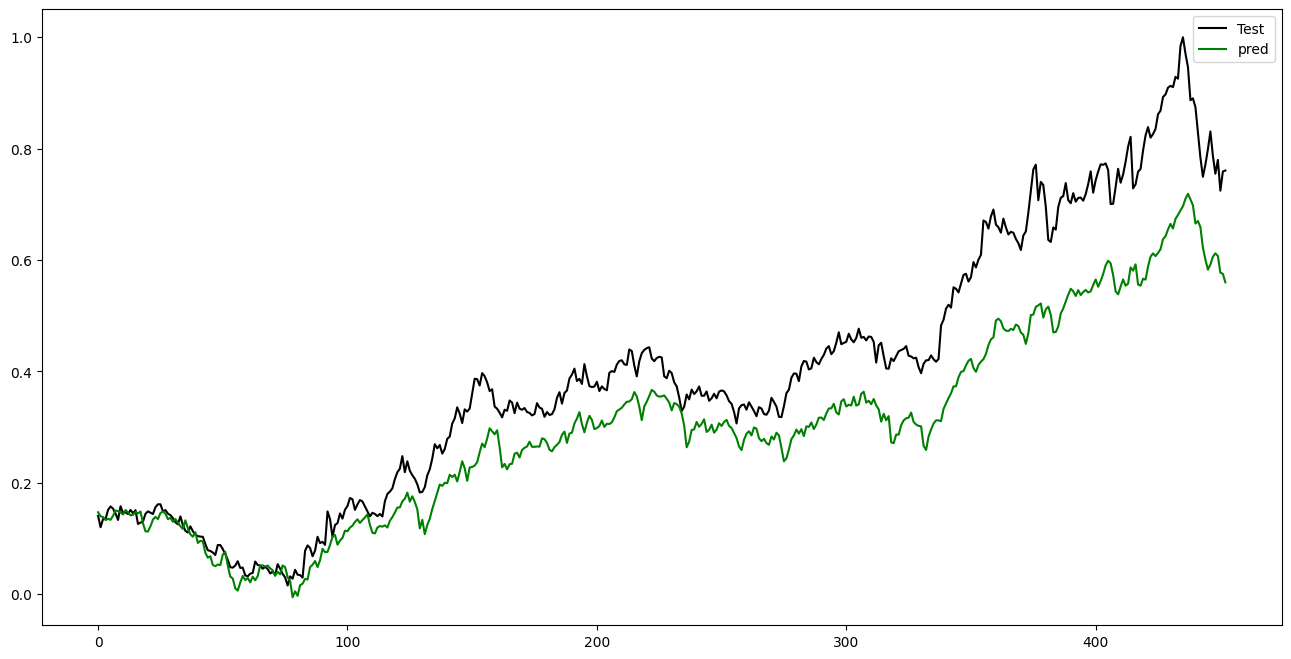

############################################################################
  Model Setup:
                    Name: XOM_F30_L150
             LSTM_Layers: 150
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: XOM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 30
  Result Data:
             mean_abs_err =1.7154647356060198
             mean_sqr_err =2.9694647586538196
        root_mean_sqr_err =1.7232134976995217
           pred_diff_mean =10.010832281384236
      pred_diff_bias_mean =-9.010832281384236
    pred_correctness_mean =0.6423841059602649



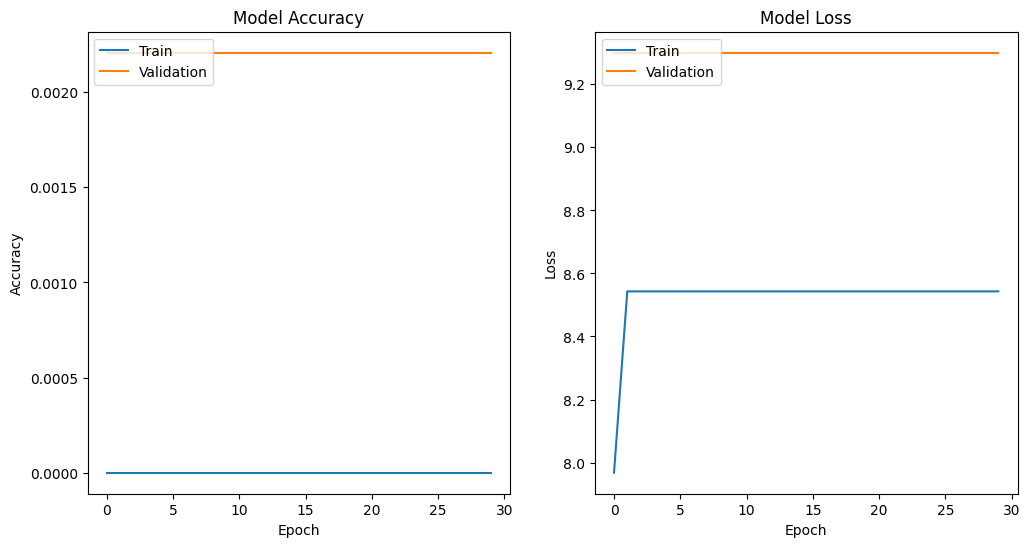

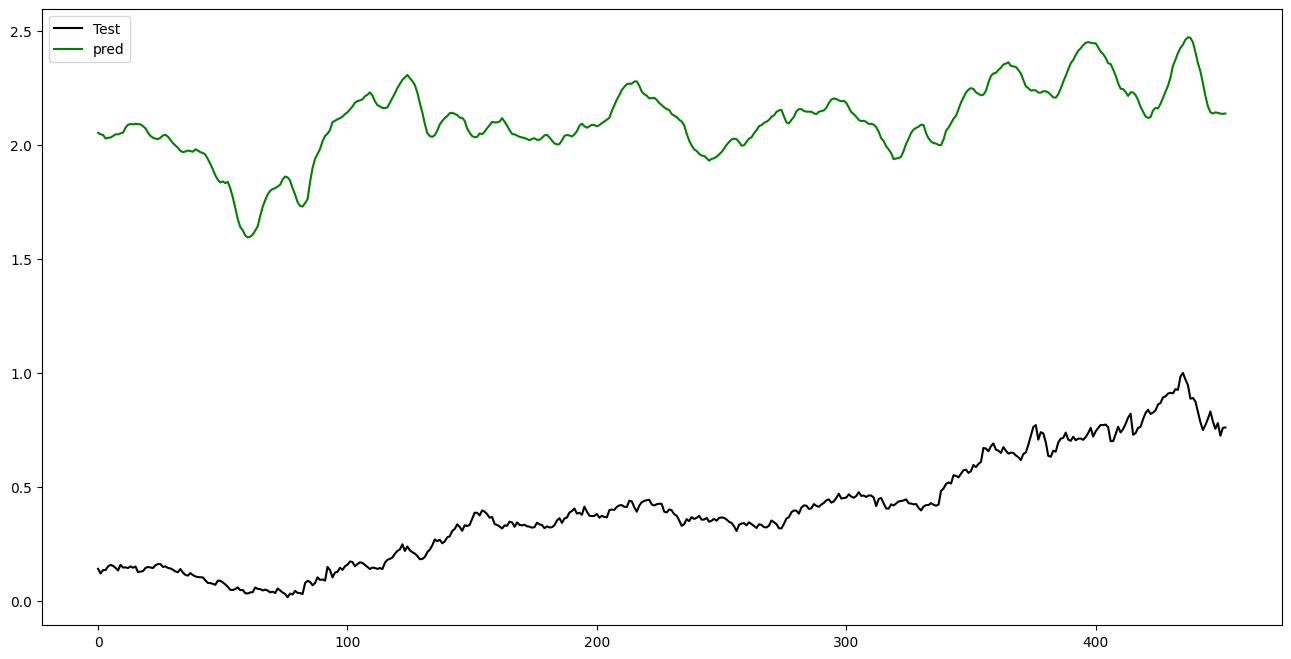

############################################################################
  Model Setup:
                    Name: XOM_F30_L250
             LSTM_Layers: 250
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: XOM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 30
  Result Data:
             mean_abs_err =0.06362190110080558
             mean_sqr_err =0.006638935137484977
        root_mean_sqr_err =0.08147966088224089
           pred_diff_mean =0.8906194430272181
      pred_diff_bias_mean =0.10938055697278201
    pred_correctness_mean =0.7483443708609272



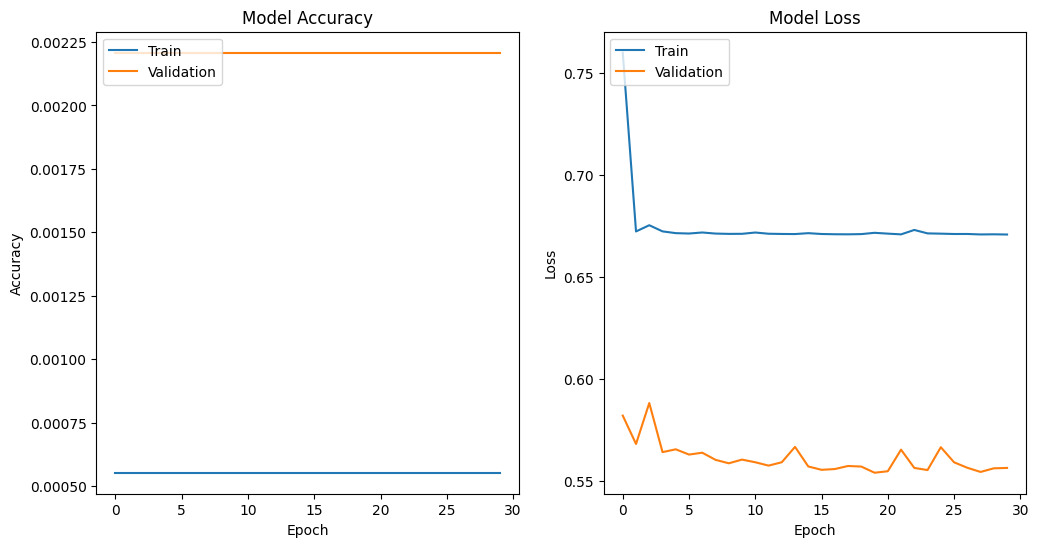

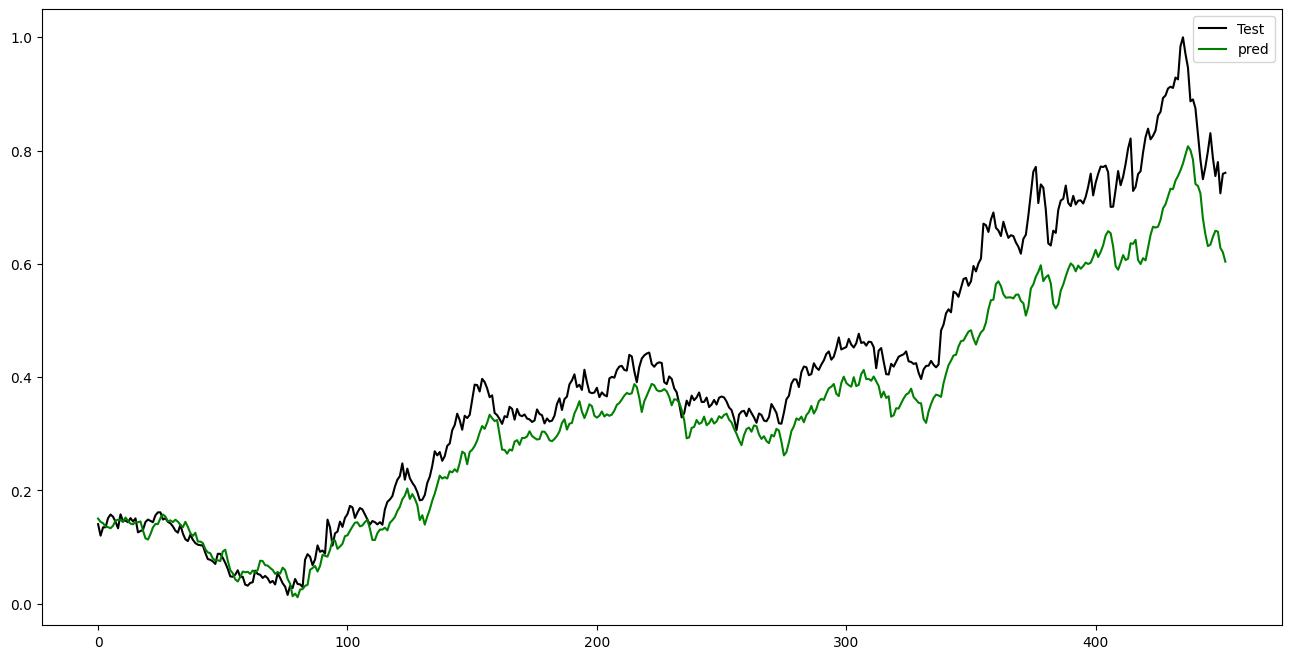

############################################################################
  Model Setup:
                    Name: XOM_F50_L50
             LSTM_Layers: 50
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: XOM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 50
  Result Data:
             mean_abs_err =0.05203405595125807
             mean_sqr_err =0.005321027679946165
        root_mean_sqr_err =0.07294537463024071
           pred_diff_mean =0.9825336469967916
      pred_diff_bias_mean =0.01746635300320839
    pred_correctness_mean =0.8930957683741648



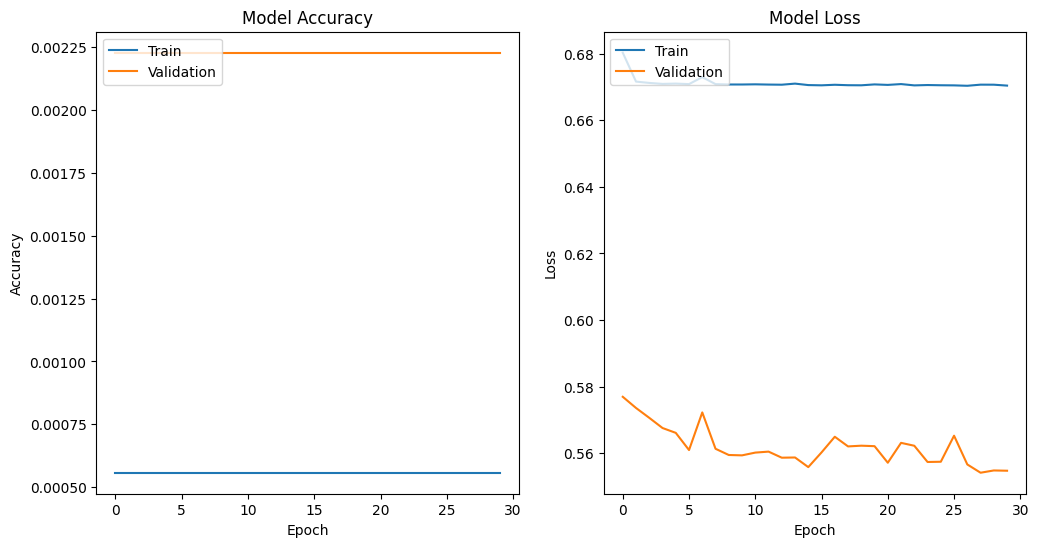

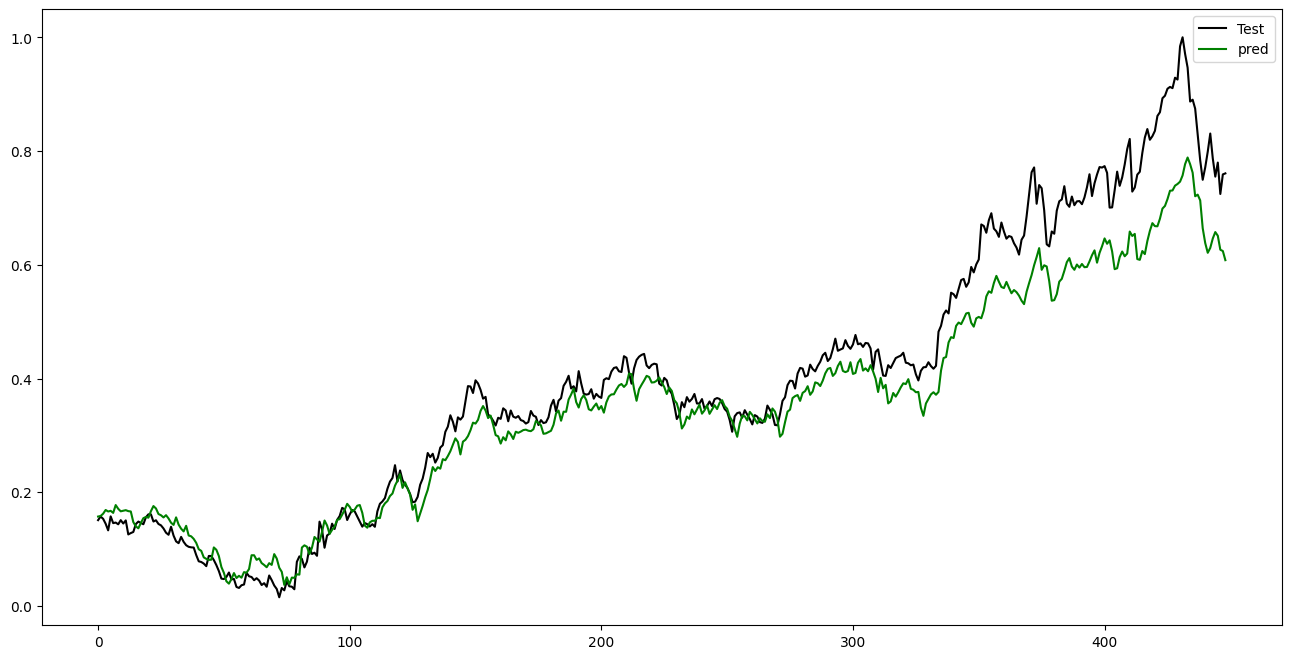

############################################################################
  Model Setup:
                    Name: XOM_F50_L150
             LSTM_Layers: 150
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: XOM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 50
  Result Data:
             mean_abs_err =0.0938963446525856
             mean_sqr_err =0.013739941725778524
        root_mean_sqr_err =0.11721749752395555
           pred_diff_mean =0.7689900850028115
      pred_diff_bias_mean =0.2310099149971885
    pred_correctness_mean =0.7394209354120267



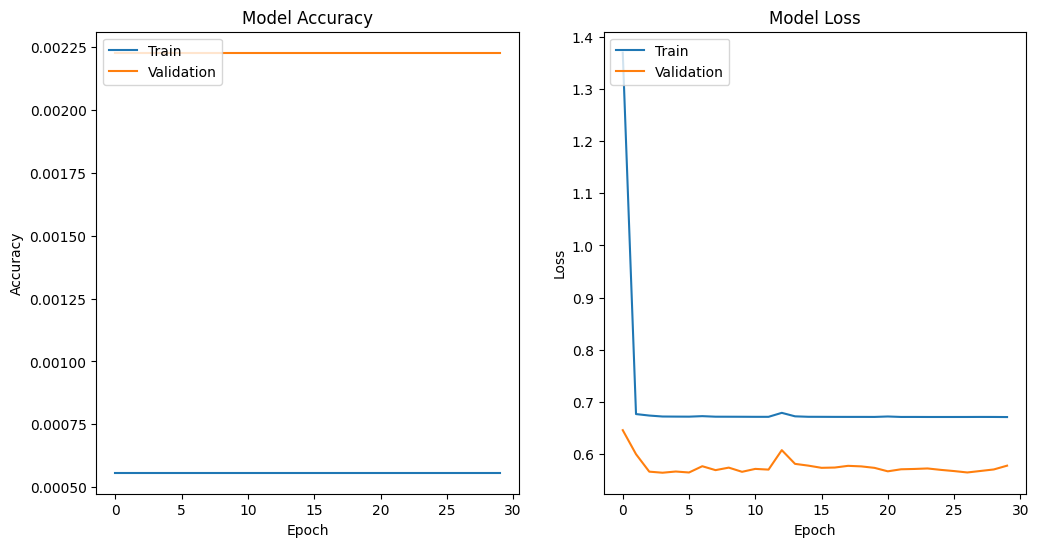

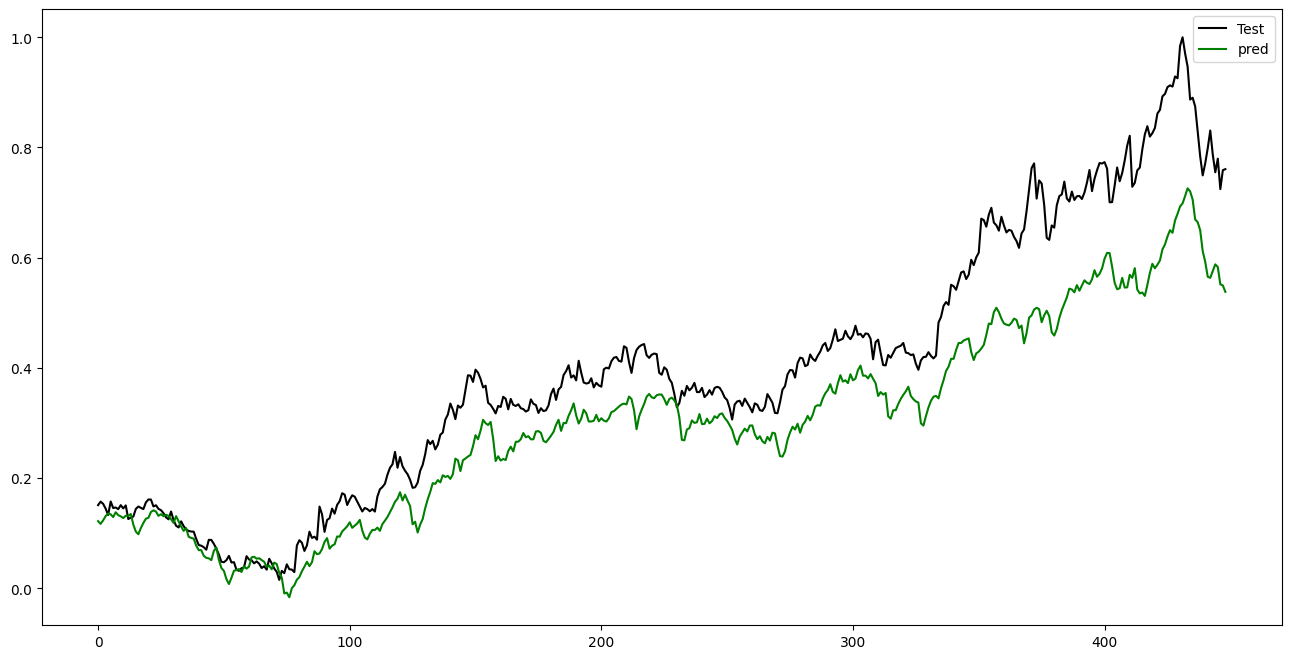

############################################################################
  Model Setup:
                    Name: XOM_F50_L250
             LSTM_Layers: 250
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: XOM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 50
  Result Data:
             mean_abs_err =0.715007067999173
             mean_sqr_err =0.5808801019556831
        root_mean_sqr_err =0.7621549067976162
           pred_diff_mean =-1.521947816266953
      pred_diff_bias_mean =2.5219478162669535
    pred_correctness_mean =0.31403118040089084



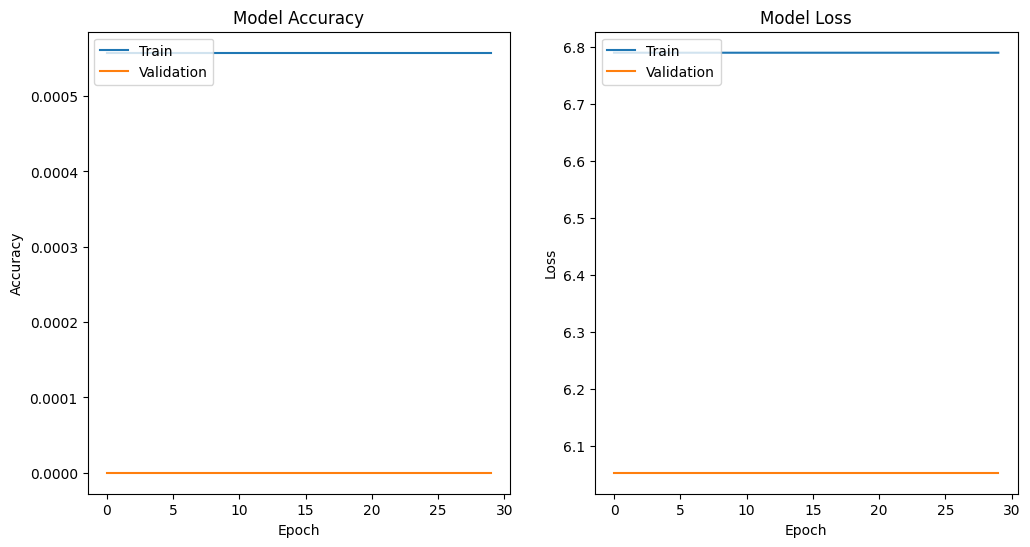

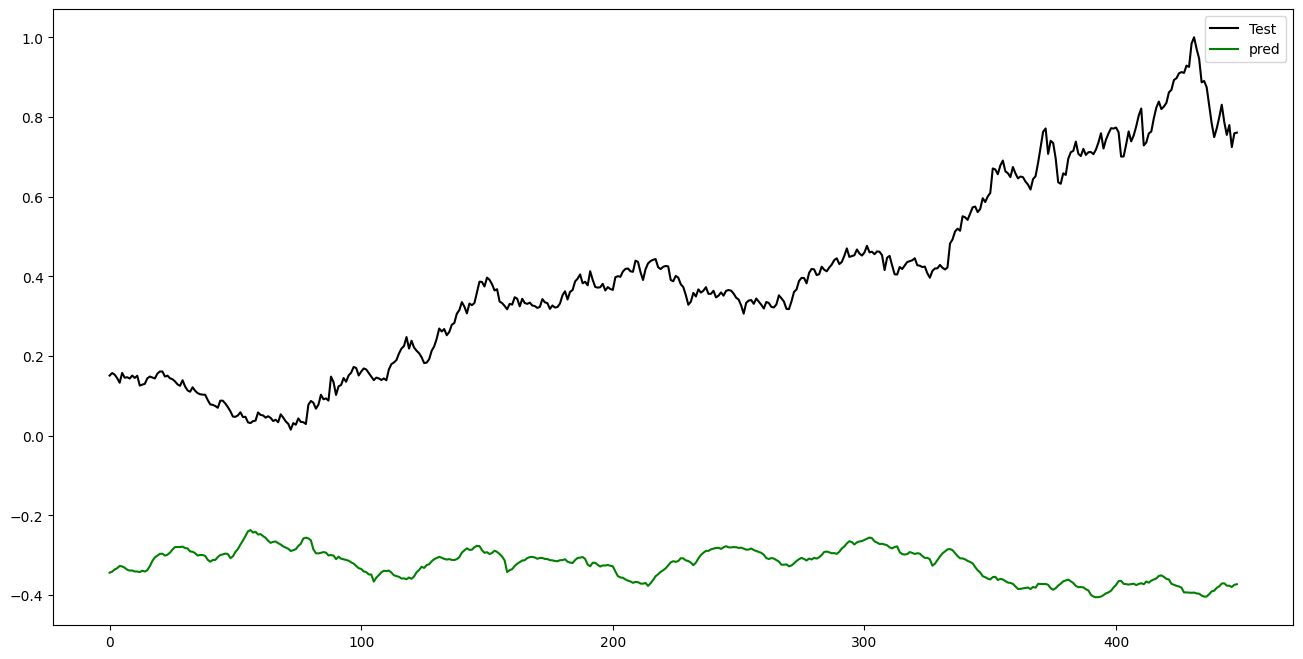

In [ ]:
for m in model_list:
  m.View_Performance_Report(show_graphs=True)


#Save Data
##Save Data to Drive

In [82]:
ls '/content/drive/MyDrive/Classes/Kent/Machine Learning/Results'

'Academic Calender 2023.gsheet'  'AI Practicum'/           'Information Visualization'/
'Advanced AI'/                   'Class Requriments.xlsx'  'Machine Learning'/
'Advanced Data Systems'/          Data_Mining/             'Software for Robotics'/
 AI/                             'Image Processing'/       'Students In Class.gsheet'


In [84]:

#Save Data
import csv

# Specify the CSV file name
filename = '/content/drive/MyDrive/Classes/Kent/Machine Learning/Results/All_Results.csv'

# Field names in the CSV file
fields = ['ModelName','Layers','Batch_Size', 'Epoch','Ticker','Indicattors','Frame_Days','mean_abs_err','mean_sqr_err','root_mean_sqr_err','pred_diff_mean','pred_diff_bias_mean',"elapsTime"]

# Writing to the csv file
with open(filename, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=fields)

    # Writing headers (field names)
    writer.writeheader()

    # Writing data of each object
    for m in model_list:
        writer.writerow({'ModelName': m.name, 'Layers': m.lstm_layers, 'Batch_Size': m.batch_size, 'Epoch':m.epochs,
                         'Ticker':m.ticker,'Indicattors':m.indicators,'Frame_Days':m.frame_days,'mean_abs_err':m.mean_abs_err,
                         'mean_sqr_err':m.mean_sqr_err,'root_mean_sqr_err':m.root_mean_sqr_err,'pred_diff_mean':m.pred_diff_mean,
                         'pred_diff_bias_mean':m.pred_diff_bias_mean,"elapsTime":m.fitting_elapse_time   })


# Get Fields








##Save Best Model to drive

In [88]:
Best_Model = max(model_list, key=lambda m:m.pred_diff_mean)

print(f"Best Model is {Best_Model.name} with {Best_Model.pred_diff_mean:.2f}%  !!!")

Best Model is ADM_F30_L150 with 0.97%  !!!
